# Improving How Neural Networks Learn: Regularization and Weight Initialization

This week, we continue improving neural networks by considering two different issues:

* Overfitting -- when we get high training accuracy, but low testing accuracy (poor generalization)
* Convergence -- getting our network to actually shrink the loss function and get good training accuracy

## Overfitting and Regularization

Any approach meant to improve overfitting is referred to as **regularization**. There are many approaches we will discuss, although we will not implement them all this week:

* $L^1$ regularization
* $L^2$ regularization
* Dropout
* Adjusting the net architecture
* Early stopping
* Gathering more data
* Artificially generating more data

### L1 and L2 Regularization

We have encountered two forms of regularization in the previous weeks in the context of linear regression: $L^1$ and $L^2$ penalties, where we add some extra terms to the loss function that aim to pressure the parameters into not growing too large, which tends to improve testing results.

#### L1 Regularization

To remind you what $L^1$ regularizatoin is, a loss function with $L^1$ regularization would be in the form

$$L(\text{weights}) = L_0(\text{weights}) + \frac{\lambda_1}{n}\sum\limits_w |w|$$,

where $L_0$ is the loss function without $L^1$ regularization. So, we add a constant times the sum of the absolute values of all the weights. This change in loss function means there will be a corresponding change in the gradient of the loss function, which we use to allow gradient descent make weight updates.

If $w>0$, the derivative of $|w|=w$ is 1. If $w<0$, the derivative of $|w|=-w$ is -1. At $w=0$, the derivative does not exist, but we will use the convention of setting it equal to 0. So, then, the derivative of the regularization term $\frac{\lambda_1}{2n}w$ for each weight is $\frac{\lambda_2}{n}\text{sign}(w)$. Therefore, the partial derivative of the loss function $L$ with respect to a weight $w$ is

$$\frac{\partial L(\text{weights})}{\partial w} = \frac{\partial L_0(\text{weights})}{\partial w} + \frac{\lambda_1}{n}\text{sign}(w)$$

#### L2 Regularization

To remind you what $L^2$ regularizatoin is, a loss function with $L^2$ regularization would be in the form

$$L(\text{weights}) = L_0(\text{weights}) + \frac{\lambda_2}{2n}\sum\limits_w w^2$$,

where $L_0$ is the loss function without $L^2$ regularization. So, we add a constant times the sum of the squares of all the weights. This change in loss function means there will be a corresponding change in the gradient of the loss function, which we use to allow gradient descent make weight updates.

The derivative of $\frac{\lambda_2}{2n}w^2$ is $\frac{\lambda_2}{n} w$, so then, the partial derivative of the loss function $L$ with respect to a weight $w$ is

$$\frac{\partial L(\text{weights})}{\partial w} = \frac{\partial L_0(\text{weights})}{\partial w} + \frac{\lambda_2}{n} w$$

#### Implementing L1 and L2 Regularization

Below is a class including all the pieces we have constructed in class or through homework so far:

* Stochastic gradient descent with customizable mini-batch size
* Three activation functions
* Two loss functions
* Periodic status updates on loss, training accuracy, and testing accuracy
* Plots of loss, training accuracy, and testing accuracy computed periodically

along with $L^1$ and $L^2$ penalties.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelBinarizer

# This class is for a fully-connected feedforward neural network using stochastic gradient descent
#
# Inputs:
#
#   layers - a list of numbers of neurons in each layer
#
#   alpha - learning rate
#
#   lambda1 - L1 penalty coefficient
#
#   lambda2 - L2 penalty coefficient
#
#   batchSize - size of mini-batches for SGD
#
#   activations - string to choose which activation functions to use:
#     'sigmoid' - sigmoid function
#     'ReLU' - rectified linear unit
#     'ELU' - exponential linear unit
#
#   loss - string to choose which loss function to use:
#     'sum-of-squares'
#     'cross-entropy'

class FeedforwardNeuralNetwork:
    
    def __init__(self, layers, alpha = 0.1, lambda1 = 0, lambda2 = 0, batchSize = 32, activations = 'sigmoid', loss = 'sum-of-squares'):
        # list of weight matrices between layers
        self.W = []
        
        # network architecture will be a vector of numbers of nodes for each layer
        self.layers = layers
        
        # learning rate
        self.alpha = alpha
        
        # L1 penalty coefficient
        self.lambda1 = lambda1
        
        # L2 penalty coefficient
        self.lambda2 = lambda2
        
        # batch size
        self.batchSize = batchSize
        
        # activation type
        self.activation = activations
        
        # loss function
        self.loss = loss
        
        # initialize the weights (randomly) -- this is our initial guess for gradient descent
        
        # initialize the weights between layers (up to the next-to-last one) as normal random variables
        for i in np.arange(0, len(layers) - 2):
            self.W.append(np.random.randn(layers[i] + 1, layers[i + 1] + 1)/100.0)
            
        # initialize weights between the last two layers (we don't want bias for the last one)
        self.W.append(np.random.randn(layers[-2] + 1, layers[-1])/100.0)
        
    # define the activation function
    def activate(self, x):
        if self.activation == 'sigmoid':
            return 1.0 / (1 + np.exp(-x))

        if self.activation == 'ReLU':
            return x*(x >= 0)
        
        if self.activation == 'ELU':
            return x*(x >= 0) + 0.1*(np.exp(x) - 1)*(x < 0)
    
    # define the activation derivative (where x is the INPUT to activation function)
    def activationDerivative(self, x):
        if self.activation == 'sigmoid':
            return self.activate(x) * (1 - self.activate(x))
        
        if self.activation == 'ReLU':
            return x >= 0
        
        if self.activation == 'ELU':
            return 1*(x >= 0) + 0.1*np.exp(x)*(x < 0)
    
    def getNextBatch(self, X, y, batchSize):
        for i in np.arange(0, X.shape[0], batchSize):
            yield (X[i:i + batchSize], y[i:i + batchSize])
    
    # fit the model
    def fit(self, X, y, testX, testY, epochs = 10000, update = 1000, printPerformance = True):
        # add a column of ones to the end of X
        X = np.hstack((X, np.ones([X.shape[0],1])))
        losses = []
        trainAccuracies = []
        testAccuracies = []
        trainY = y
        
        numberOfExamples = X.shape[0]
        
        # use one-hot encoding for the training labels
        y = LabelBinarizer().fit_transform(y)

        for epoch in np.arange(0,epochs):
            
            # randomize the examples
            p = np.arange(0,X.shape[0])
            np.random.shuffle(p)
            X = X[p]
            y = y[p]

            # feed forward, backprop, and weight update
            for (x, target) in self.getNextBatch(X, y, self.batchSize):
                # make a list of output activations from the first layer
                # (just the original x values)
                A = [np.atleast_2d(x)]
                Z = [np.atleast_2d(x)]
                
                # feed forward
                for layer in np.arange(0, len(self.W)):
                    
                    # feed through one layer and apply sigmoid activation
                    net = A[layer].dot(self.W[layer])
                    out = self.activate(net)
                    
                    # add our network output to the list of activations
                    A.append(out)
                    Z.append(net)
                    
                # backpropagation (coming soon!)
                error = A[-1] - target
                
                if self.loss == 'sum-of-squares':
                    D = [error * self.activationDerivative(Z[-1])]
                    
                if self.loss == 'cross-entropy':
                    D = [error]
                
                # loop backwards over the layers to build up deltas
                for layer in np.arange(len(A) - 2, 0, -1):
                    delta = D[-1].dot(self.W[layer].T)
                    delta = delta * self.activationDerivative(Z[layer])
                    D.append(delta)
                    
                # reverse the deltas since we looped in reverse
                D = D[::-1]
                
                # weight update
                for layer in np.arange(0, len(self.W)):
                    self.W[layer] -= self.alpha * (A[layer].T.dot(D[layer])
                                                   + 2 * (self.lambda2 / numberOfExamples) * self.W[layer]
                                                   + (self.lambda1 / numberOfExamples) * np.sign(self.W[layer])*self.W[layer])
              
            # print the loss (or maybe more) each 'update' number of epochs
            if (epoch + 1) % update == 0:
                loss = self.computeLoss(X,y)

                # if we chose, compute the accuracy (this makes it run slower)
                if printPerformance:
                    predictedY = self.predict(testX)
                    predictedY = predictedY.argmax(axis=1)
                    testAccuracy = accuracy_score(testY, predictedY)           

                    predictedY = self.predict(trainX)
                    predictedY = predictedY.argmax(axis=1)
                    trainAccuracy = accuracy_score(trainY, predictedY)

                    testAccuracies.append(testAccuracy)
                    trainAccuracies.append(trainAccuracy)
                    losses.append(loss)
                    #print("[INFO] epoch = {}, loss = {:.6f}, training accuracy = {:.6f}, test accuracy = {:.6f}".format(epoch + 1, loss, trainAccuracy, testAccuracy))
                    
                # otherwise, simply print the training loss
                else:
                    losses.append(loss)
                    print("[INFO] epoch = {}, loss = {:.6f}".format(epoch + 1, loss))

        # if we chose to print the performance, plot loss, training accuracy, and test accuracy for each epoch
        if printPerformance:
            fig, ax1 = plt.subplots()

            # plot the losses
            p1 = ax1.plot(np.arange(0, epochs, update), losses, label = 'Loss')
            ax1.set_xlabel('Training Epoch')
            ax1.set_ylabel('Loss')

            # make another y axis using the same x axis
            ax2 = ax1.twinx()
            
            # plot the accuracy
            p2 = ax2.plot(np.arange(0, epochs, update), trainAccuracies, label = 'Accuracy (train)', color = 'tab:orange')
            p3 = ax2.plot(np.arange(0, epochs, update), testAccuracies, label = 'Accuracy (test)', color = 'tab:green')
            ax2.set_ylabel('Accuracy')

            # add a legend
            ps = p1 + p2 + p3
            labs = [p.get_label() for p in ps]
            ax1.legend(ps, labs, loc=0)
            
    # feed data into the network and compute the outputs
    def predict(self, X, addOnes = True):
        # initialize data, be sure it's the right dimension
        p = np.atleast_2d(X)
        
        # add a column of 1s for bias
        if addOnes:
            p = np.hstack((p, np.ones([X.shape[0],1])))
        
        # feed forward!
        for layer in np.arange(0, len(self.W)):
            p = self.activate(np.dot(p, self.W[layer]))
            
        return p
    
    # compute the loss function
    def computeLoss(self, X, y):
        # initialize data, be sure it's the right dimension
        y = np.atleast_2d(y)
        
        # feed the datapoints through the network to get predicted outputs
        predictions = self.predict(X, addOnes = False)
        
        # if the loss function is sum of squares, compute it
        if self.loss == 'sum-of-squares':
            loss = np.sum((predictions - y)**2) / 2.0
            
        # if the loss function is cross-entropy, compute it
        if self.loss == 'cross-entropy':
            loss = np.sum(np.nan_to_num(-y*np.log(predictions)-(1-y)*np.log(1-predictions)))
            
        # if there is an L1 penalty, compute it and add it to the loss
        if self.lambda1 != 0:
            # compute the L1 penalty 
            L1penalty = 0

            for layer in np.arange(0,len(self.W)):
                L1penalty += np.sum(np.abs(self.W[layer]))
        
            # add the L1 penalty to the loss
            loss = loss + (self.lambda1 / X.shape[0]) * L1penalty
            
        # if there is an L2 penalty, compute it and add it to the loss
        if self.lambda2 != 0:
            # compute the L2 penalty 
            L2penalty = 0

            for layer in np.arange(0,len(self.W)):
                L2penalty += np.sum(self.W[layer] ** 2)
        
            # add the L2 penalty to the loss
            loss = loss + (self.lambda2 / X.shape[0]) * L2penalty
        
        return loss

#### Testing L1 and L2 Regularization

Let's run it on MNIST without regularization just to see that the code works.

In [4]:
# import mnist and some functions we need
from tensorflow.keras.datasets import mnist
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

C:\Users\Ryan\anaconda3\envs\DL\lib\site-packages\ipykernel_launcher.py:230: RuntimeWarning: divide by zero encountered in log
C:\Users\Ryan\anaconda3\envs\DL\lib\site-packages\ipykernel_launcher.py:230: RuntimeWarning: invalid value encountered in multiply
C:\Users\Ryan\anaconda3\envs\DL\lib\site-packages\numpy\core\fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\Ryan\anaconda3\envs\DL\lib\site-packages\ipykernel_launcher.py:230: RuntimeWarning: invalid value encountered in log
C:\Users\Ryan\anaconda3\envs\DL\lib\site-packages\matplotlib\axes\_base.py:2450: RuntimeWarning: overflow encountered in double_scalars
  x0, x1 = inverse_trans.transform([x0t - delta, x1t + delta])


Test set accuracy
              precision    recall  f1-score   support

           0       0.91      0.95      0.93        22
           1       1.00      1.00      1.00        30
           2       1.00      0.91      0.95        23
           3       0.88      0.85      0.87        27
           4       0.87      0.80      0.83        25
           5       0.74      0.81      0.77        21
           6       0.83      0.90      0.86        21
           7       0.93      0.93      0.93        27
           8       0.90      0.72      0.80        25
           9       0.71      0.83      0.76        29

    accuracy                           0.87       250
   macro avg       0.88      0.87      0.87       250
weighted avg       0.88      0.87      0.87       250



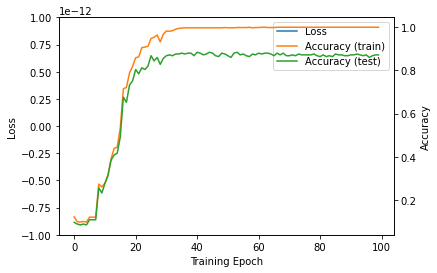

In [7]:
### CLASSIFY MNIST PICTURES

# create a dataset of 1000 MNIST images, reshaped as single vectors, and labels
data = mnist.load_data()

# The datapoints are in mnistData[0][0]
X = data[0][0][:1000].reshape([1000,28*28])
X = X/255.0

# The labels are in mnistData[0][1]
Y = data[0][1][:1000]

# randomly choose 75% of the data to be the training set and 25% for the testing set
(trainX, testX, trainY, testY) = train_test_split(X, Y, test_size = 0.25)

# fit the model to the training data
model = FeedforwardNeuralNetwork([784, 32, 16, 10], 0.01, 0.0, 0.0, 32, 'ReLU', 'cross-entropy')
model.fit(trainX, trainY, testX, testY, 100, 1)

print("Test set accuracy")
testY = LabelBinarizer().fit_transform(testY)
predictedY = model.predict(testX)
predictedY = predictedY.argmax(axis=1)

testY = testY.argmax(axis=1)
print(classification_report(testY, predictedY))

Let's add L2 penalty

C:\Users\Ryan\anaconda3\envs\DL\lib\site-packages\ipykernel_launcher.py:230: RuntimeWarning: divide by zero encountered in log
C:\Users\Ryan\anaconda3\envs\DL\lib\site-packages\ipykernel_launcher.py:230: RuntimeWarning: invalid value encountered in multiply
C:\Users\Ryan\anaconda3\envs\DL\lib\site-packages\numpy\core\fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\Ryan\anaconda3\envs\DL\lib\site-packages\ipykernel_launcher.py:230: RuntimeWarning: invalid value encountered in log
C:\Users\Ryan\anaconda3\envs\DL\lib\site-packages\matplotlib\axes\_base.py:2450: RuntimeWarning: overflow encountered in double_scalars
  x0, x1 = inverse_trans.transform([x0t - delta, x1t + delta])


Test set accuracy
              precision    recall  f1-score   support

           0       0.85      0.88      0.87        26
           1       0.94      0.97      0.95        31
           2       0.84      0.80      0.82        20
           3       0.81      0.72      0.76        18
           4       0.87      0.94      0.90        35
           5       0.83      0.77      0.80        26
           6       0.88      1.00      0.93        21
           7       0.88      0.79      0.84        29
           8       0.82      0.82      0.82        22
           9       0.82      0.82      0.82        22

    accuracy                           0.86       250
   macro avg       0.85      0.85      0.85       250
weighted avg       0.86      0.86      0.86       250



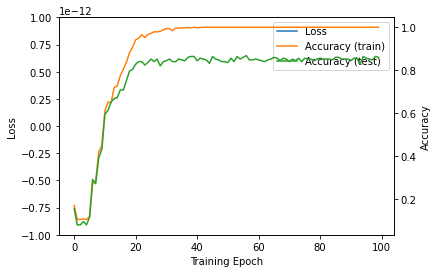

In [31]:
### CLASSIFY MNIST PICTURES

# create a dataset of 1000 MNIST images, reshaped as single vectors, and labels
data = mnist.load_data()

# The datapoints are in mnistData[0][0]
X = data[0][0][:1000].reshape([1000,28*28])
X = X/255.0

# The labels are in mnistData[0][1]
Y = data[0][1][:1000]

# randomly choose 75% of the data to be the training set and 25% for the testing set
(trainX, testX, trainY, testY) = train_test_split(X, Y, test_size = 0.25)

# fit the model to the training data
model = FeedforwardNeuralNetwork([784, 32, 16, 10], 0.01, 0.0, 10.0, 32, 'ReLU', 'cross-entropy')
model.fit(trainX, trainY, testX, testY, 100, 1)

print("Test set accuracy")
testY = LabelBinarizer().fit_transform(testY)
predictedY = model.predict(testX)
predictedY = predictedY.argmax(axis=1)

testY = testY.argmax(axis=1)
print(classification_report(testY, predictedY))

That worked, so let's try some more

C:\Users\Ryan\anaconda3\envs\DL\lib\site-packages\ipykernel_launcher.py:230: RuntimeWarning: divide by zero encountered in log
C:\Users\Ryan\anaconda3\envs\DL\lib\site-packages\ipykernel_launcher.py:230: RuntimeWarning: invalid value encountered in multiply
C:\Users\Ryan\anaconda3\envs\DL\lib\site-packages\numpy\core\fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\Ryan\anaconda3\envs\DL\lib\site-packages\ipykernel_launcher.py:230: RuntimeWarning: invalid value encountered in log
C:\Users\Ryan\anaconda3\envs\DL\lib\site-packages\matplotlib\axes\_base.py:2450: RuntimeWarning: overflow encountered in double_scalars
  x0, x1 = inverse_trans.transform([x0t - delta, x1t + delta])


Test set accuracy
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        27
           1       0.89      0.89      0.89        28
           2       0.89      0.81      0.85        31
           3       0.83      0.88      0.86        17
           4       0.88      0.96      0.92        24
           5       0.74      0.87      0.80        23
           6       0.89      0.96      0.93        26
           7       0.87      0.87      0.87        30
           8       0.83      0.62      0.71        24
           9       0.85      0.85      0.85        20

    accuracy                           0.87       250
   macro avg       0.87      0.87      0.87       250
weighted avg       0.87      0.87      0.87       250



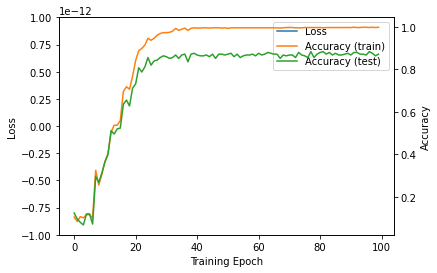

In [32]:
### CLASSIFY MNIST PICTURES

# create a dataset of 1000 MNIST images, reshaped as single vectors, and labels
data = mnist.load_data()

# The datapoints are in mnistData[0][0]
X = data[0][0][:1000].reshape([1000,28*28])
X = X/255.0

# The labels are in mnistData[0][1]
Y = data[0][1][:1000]

# randomly choose 75% of the data to be the training set and 25% for the testing set
(trainX, testX, trainY, testY) = train_test_split(X, Y, test_size = 0.25)

# fit the model to the training data
model = FeedforwardNeuralNetwork([784, 32, 16, 10], 0.01, 0.0, 50.0, 32, 'ReLU', 'cross-entropy')
model.fit(trainX, trainY, testX, testY, 100, 1)

print("Test set accuracy")
testY = LabelBinarizer().fit_transform(testY)
predictedY = model.predict(testX)
predictedY = predictedY.argmax(axis=1)

testY = testY.argmax(axis=1)
print(classification_report(testY, predictedY))

$\lambda_2=50.0$ seemed to be too much, as performance declined from $\lambda_2=10.0$.

Let's try just L1 penalty now.

C:\Users\Ryan\anaconda3\envs\DL\lib\site-packages\ipykernel_launcher.py:230: RuntimeWarning: divide by zero encountered in log
C:\Users\Ryan\anaconda3\envs\DL\lib\site-packages\ipykernel_launcher.py:230: RuntimeWarning: invalid value encountered in multiply
C:\Users\Ryan\anaconda3\envs\DL\lib\site-packages\numpy\core\fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\Ryan\anaconda3\envs\DL\lib\site-packages\ipykernel_launcher.py:230: RuntimeWarning: invalid value encountered in log


Test set accuracy
              precision    recall  f1-score   support

           0       0.71      1.00      0.83        15
           1       0.96      1.00      0.98        27
           2       0.93      0.93      0.93        29
           3       0.88      0.81      0.84        26
           4       0.72      0.78      0.75        23
           5       0.88      0.58      0.70        26
           6       1.00      0.84      0.91        25
           7       0.91      0.85      0.88        34
           8       0.70      0.88      0.78        16
           9       0.67      0.76      0.71        29

    accuracy                           0.84       250
   macro avg       0.84      0.84      0.83       250
weighted avg       0.85      0.84      0.84       250



C:\Users\Ryan\anaconda3\envs\DL\lib\site-packages\matplotlib\axes\_base.py:2450: RuntimeWarning: overflow encountered in double_scalars
  x0, x1 = inverse_trans.transform([x0t - delta, x1t + delta])


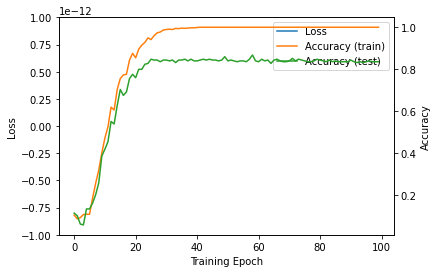

In [33]:
### CLASSIFY MNIST PICTURES

# create a dataset of 1000 MNIST images, reshaped as single vectors, and labels
data = mnist.load_data()

# The datapoints are in mnistData[0][0]
X = data[0][0][:1000].reshape([1000,28*28])
X = X/255.0

# The labels are in mnistData[0][1]
Y = data[0][1][:1000]

# randomly choose 75% of the data to be the training set and 25% for the testing set
(trainX, testX, trainY, testY) = train_test_split(X, Y, test_size = 0.25)

# fit the model to the training data
model = FeedforwardNeuralNetwork([784, 32, 16, 10], 0.01, 10.0, 0.0, 32, 'ReLU', 'cross-entropy')
model.fit(trainX, trainY, testX, testY, 100, 1)

print("Test set accuracy")
testY = LabelBinarizer().fit_transform(testY)
predictedY = model.predict(testX)
predictedY = predictedY.argmax(axis=1)

testY = testY.argmax(axis=1)
print(classification_report(testY, predictedY))

C:\Users\Ryan\anaconda3\envs\DL\lib\site-packages\ipykernel_launcher.py:230: RuntimeWarning: divide by zero encountered in log
C:\Users\Ryan\anaconda3\envs\DL\lib\site-packages\ipykernel_launcher.py:230: RuntimeWarning: invalid value encountered in multiply
C:\Users\Ryan\anaconda3\envs\DL\lib\site-packages\numpy\core\fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\Ryan\anaconda3\envs\DL\lib\site-packages\ipykernel_launcher.py:230: RuntimeWarning: invalid value encountered in log
C:\Users\Ryan\anaconda3\envs\DL\lib\site-packages\matplotlib\axes\_base.py:2450: RuntimeWarning: overflow encountered in double_scalars
  x0, x1 = inverse_trans.transform([x0t - delta, x1t + delta])
C:\Users\Ryan\anaconda3\envs\DL\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` 

Test set accuracy
              precision    recall  f1-score   support

           0       0.14      1.00      0.25        36
           1       0.00      0.00      0.00        26
           2       0.00      0.00      0.00        30
           3       0.00      0.00      0.00        17
           4       0.00      0.00      0.00        35
           5       0.00      0.00      0.00        23
           6       0.00      0.00      0.00        20
           7       0.00      0.00      0.00        27
           8       0.00      0.00      0.00        16
           9       0.00      0.00      0.00        20

    accuracy                           0.14       250
   macro avg       0.01      0.10      0.03       250
weighted avg       0.02      0.14      0.04       250



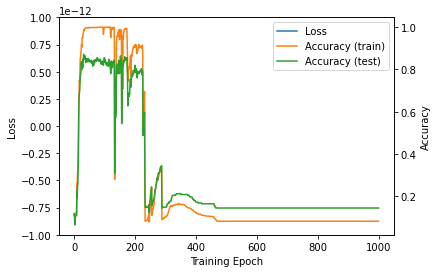

In [34]:
### CLASSIFY MNIST PICTURES

# create a dataset of 1000 MNIST images, reshaped as single vectors, and labels
data = mnist.load_data()

# The datapoints are in mnistData[0][0]
X = data[0][0][:1000].reshape([1000,28*28])
X = X/255.0

# The labels are in mnistData[0][1]
Y = data[0][1][:1000]

# randomly choose 75% of the data to be the training set and 25% for the testing set
(trainX, testX, trainY, testY) = train_test_split(X, Y, test_size = 0.25)

# fit the model to the training data
model = FeedforwardNeuralNetwork([784, 32, 16, 10], 0.01, 50.0, 0.0, 32, 'ReLU', 'cross-entropy')
model.fit(trainX, trainY, testX, testY, 1000, 1)

print("Test set accuracy")
testY = LabelBinarizer().fit_transform(testY)
predictedY = model.predict(testX)
predictedY = predictedY.argmax(axis=1)

testY = testY.argmax(axis=1)
print(classification_report(testY, predictedY))

With too much $L^1$ regularization, we see another issue that can happen: worsening results from **overtraining** the network for 1000 epochs, which caused lots of over-fitting and then loss of training accuracy.

However, our outputs tell us that the performance was good near epoch 100 and then started to decline. Another technique for regularization and generally getting better results is **early stopping** of the training. When we output status updates, we can see when the performance starts to suffer and know to only train for fewer epochs.

In very expensive computational examples, it is good practice to store the weights that gave the best test accuracy through the course of training so that some code that was stopped early can still output the best weights. You can also stop training when it becomes clear the net has stagnated.

Lastly, let's try $L^1$ and $L^2$ regularization simultaneously.

C:\Users\Ryan\anaconda3\envs\DL\lib\site-packages\ipykernel_launcher.py:230: RuntimeWarning: divide by zero encountered in log
C:\Users\Ryan\anaconda3\envs\DL\lib\site-packages\ipykernel_launcher.py:230: RuntimeWarning: invalid value encountered in multiply
C:\Users\Ryan\anaconda3\envs\DL\lib\site-packages\numpy\core\fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\Ryan\anaconda3\envs\DL\lib\site-packages\ipykernel_launcher.py:230: RuntimeWarning: invalid value encountered in log
C:\Users\Ryan\anaconda3\envs\DL\lib\site-packages\matplotlib\axes\_base.py:2450: RuntimeWarning: overflow encountered in double_scalars
  x0, x1 = inverse_trans.transform([x0t - delta, x1t + delta])


Test set accuracy
              precision    recall  f1-score   support

           0       1.00      0.89      0.94        27
           1       0.91      0.88      0.90        34
           2       1.00      0.74      0.85        27
           3       0.83      0.80      0.82        25
           4       0.75      0.79      0.77        19
           5       0.72      0.75      0.73        24
           6       0.67      0.87      0.75        23
           7       0.93      0.96      0.95        28
           8       0.73      0.80      0.76        20
           9       0.83      0.83      0.83        23

    accuracy                           0.84       250
   macro avg       0.84      0.83      0.83       250
weighted avg       0.85      0.84      0.84       250



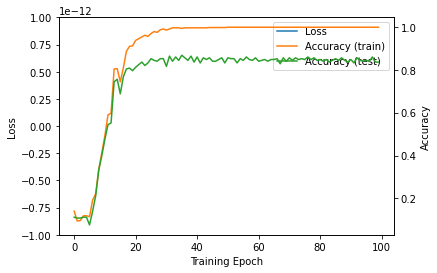

In [35]:
### CLASSIFY MNIST PICTURES

# create a dataset of 1000 MNIST images, reshaped as single vectors, and labels
data = mnist.load_data()

# The datapoints are in mnistData[0][0]
X = data[0][0][:1000].reshape([1000,28*28])
X = X/255.0

# The labels are in mnistData[0][1]
Y = data[0][1][:1000]

# randomly choose 75% of the data to be the training set and 25% for the testing set
(trainX, testX, trainY, testY) = train_test_split(X, Y, test_size = 0.25)

# fit the model to the training data
model = FeedforwardNeuralNetwork([784, 32, 16, 10], 0.01, 5.0, 5.0, 32, 'ReLU', 'cross-entropy')
model.fit(trainX, trainY, testX, testY, 100, 1)

print("Test set accuracy")
testY = LabelBinarizer().fit_transform(testY)
predictedY = model.predict(testX)
predictedY = predictedY.argmax(axis=1)

testY = testY.argmax(axis=1)
print(classification_report(testY, predictedY))

Performance is similar to when using moderate values of $\lambda_1$ and $\lambda_2$ in isolation in this example. However, all datasets are different, so sometimes one works better than the other, or some combination of the two (the elastic-net loss) will perform better than either one in isolation.

### Adding Data

Using larger datasets also has a naturally regularizing effect. Let's adjust our code above by testing different size datasets

Test for 1000 images


C:\Users\Ryan\anaconda3\envs\DL\lib\site-packages\ipykernel_launcher.py:230: RuntimeWarning: divide by zero encountered in log
C:\Users\Ryan\anaconda3\envs\DL\lib\site-packages\ipykernel_launcher.py:230: RuntimeWarning: invalid value encountered in multiply
C:\Users\Ryan\anaconda3\envs\DL\lib\site-packages\numpy\core\fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\Ryan\anaconda3\envs\DL\lib\site-packages\ipykernel_launcher.py:230: RuntimeWarning: invalid value encountered in log
C:\Users\Ryan\anaconda3\envs\DL\lib\site-packages\matplotlib\axes\_base.py:2450: RuntimeWarning: overflow encountered in double_scalars
  x0, x1 = inverse_trans.transform([x0t - delta, x1t + delta])


Training set accuracy
1.0
Test set accuracy
0.904


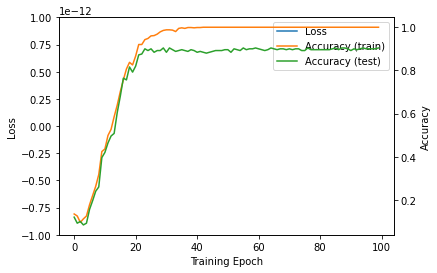

In [40]:
### CLASSIFY MNIST PICTURES

# create a dataset of 1000 MNIST images, reshaped as single vectors, and labels
data = mnist.load_data()

print('Test for 1000 images')

# The datapoints are in mnistData[0][0]
X = data[0][0][:1000].reshape([1000,28*28])
X = X/255.0

# The labels are in mnistData[0][1]
Y = data[0][1][:1000]

# randomly choose 75% of the data to be the training set and 25% for the testing set
(trainX, testX, trainY, testY) = train_test_split(X, Y, test_size = 0.25)

# fit the model to the training data
model = FeedforwardNeuralNetwork([784, 32, 16, 10], 0.01, 5.0, 5.0, 32, 'ReLU', 'cross-entropy')
model.fit(trainX, trainY, testX, testY, 100, 1)

print("Training set accuracy")
trainY = LabelBinarizer().fit_transform(trainY)
predictedY = model.predict(trainX)
predictedY = predictedY.argmax(axis=1)
trainY = trainY.argmax(axis=1)
print(accuracy_score(trainY, predictedY))

print("Test set accuracy")
testY = LabelBinarizer().fit_transform(testY)
predictedY = model.predict(testX)
predictedY = predictedY.argmax(axis=1)
testY = testY.argmax(axis=1)
print(accuracy_score(testY, predictedY))

Test for 10000 images


C:\Users\Ryan\anaconda3\envs\DL\lib\site-packages\ipykernel_launcher.py:230: RuntimeWarning: divide by zero encountered in log
C:\Users\Ryan\anaconda3\envs\DL\lib\site-packages\ipykernel_launcher.py:230: RuntimeWarning: invalid value encountered in multiply
C:\Users\Ryan\anaconda3\envs\DL\lib\site-packages\ipykernel_launcher.py:230: RuntimeWarning: invalid value encountered in log
C:\Users\Ryan\anaconda3\envs\DL\lib\site-packages\numpy\core\fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\Ryan\anaconda3\envs\DL\lib\site-packages\matplotlib\axes\_base.py:2450: RuntimeWarning: overflow encountered in double_scalars
  x0, x1 = inverse_trans.transform([x0t - delta, x1t + delta])


Training set accuracy
1.0
Test set accuracy
0.9444


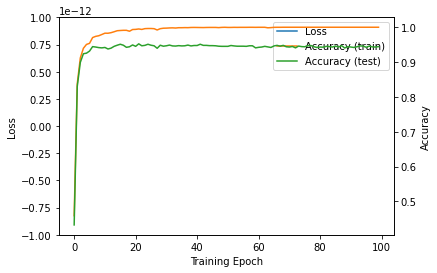

In [45]:
print('Test for 10000 images')

# The datapoints are in mnistData[0][0]
X = data[0][0][:10000].reshape([10000,28*28])
X = X/255.0

# The labels are in mnistData[0][1]
Y = data[0][1][:10000]

# randomly choose 75% of the data to be the training set and 25% for the testing set
(trainX, testX, trainY, testY) = train_test_split(X, Y, test_size = 0.25)

# fit the model to the training data
model = FeedforwardNeuralNetwork([784, 32, 16, 10], 0.01, 5.0, 5.0, 32, 'ReLU', 'cross-entropy')
model.fit(trainX, trainY, testX, testY, 100, 1)

print("Training set accuracy")
trainY = LabelBinarizer().fit_transform(trainY)
predictedY = model.predict(trainX)
predictedY = predictedY.argmax(axis=1)
trainY = trainY.argmax(axis=1)
print(accuracy_score(trainY, predictedY))

print("Test set accuracy")
testY = LabelBinarizer().fit_transform(testY)
predictedY = model.predict(testX)
predictedY = predictedY.argmax(axis=1)
testY = testY.argmax(axis=1)
print(accuracy_score(testY, predictedY))

Test for 60000 images


C:\Users\Ryan\anaconda3\envs\DL\lib\site-packages\ipykernel_launcher.py:230: RuntimeWarning: divide by zero encountered in log
C:\Users\Ryan\anaconda3\envs\DL\lib\site-packages\ipykernel_launcher.py:230: RuntimeWarning: invalid value encountered in multiply
C:\Users\Ryan\anaconda3\envs\DL\lib\site-packages\ipykernel_launcher.py:230: RuntimeWarning: invalid value encountered in log
C:\Users\Ryan\anaconda3\envs\DL\lib\site-packages\numpy\core\fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Training set accuracy
0.9958222222222223
Test set accuracy
0.9566


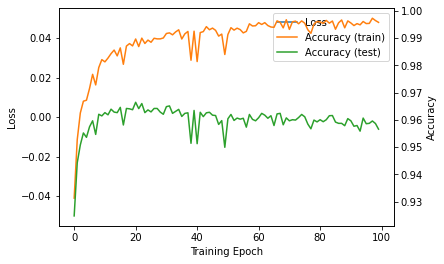

In [44]:
print('Test for 60000 images')

# The datapoints are in mnistData[0][0]
X = data[0][0][:].reshape([60000,28*28])
X = X/255.0

# The labels are in mnistData[0][1]
Y = data[0][1][:]

# randomly choose 75% of the data to be the training set and 25% for the testing set
(trainX, testX, trainY, testY) = train_test_split(X, Y, test_size = 0.25)

# fit the model to the training data
model = FeedforwardNeuralNetwork([784, 32, 16, 10], 0.01, 5.0, 5.0, 32, 'ReLU', 'cross-entropy')
model.fit(trainX, trainY, testX, testY, 100, 1)

print("Training set accuracy")
trainY = LabelBinarizer().fit_transform(trainY)
predictedY = model.predict(trainX)
predictedY = predictedY.argmax(axis=1)
trainY = trainY.argmax(axis=1)
print(accuracy_score(trainY, predictedY))

print("Test set accuracy")
testY = LabelBinarizer().fit_transform(testY)
predictedY = model.predict(testX)
predictedY = predictedY.argmax(axis=1)
testY = testY.argmax(axis=1)
print(accuracy_score(testY, predictedY))

Test for 60000 images


C:\Users\Ryan\anaconda3\envs\DL\lib\site-packages\ipykernel_launcher.py:230: RuntimeWarning: divide by zero encountered in log
C:\Users\Ryan\anaconda3\envs\DL\lib\site-packages\ipykernel_launcher.py:230: RuntimeWarning: invalid value encountered in multiply
C:\Users\Ryan\anaconda3\envs\DL\lib\site-packages\ipykernel_launcher.py:230: RuntimeWarning: invalid value encountered in log
C:\Users\Ryan\anaconda3\envs\DL\lib\site-packages\numpy\core\fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Training set accuracy
0.9939
Test set accuracy
0.9639


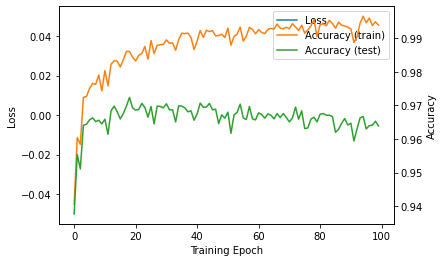

In [46]:
print('Test for 70000 images')

# The datapoints are in mnistData[0][0]
trainX = data[0][0][:].reshape([60000,28*28])
testX = data[1][0][:].reshape([10000,28*28])

trainX = trainX/255.0
testX = testX/255.0

# The labels are in mnistData[0][1]
trainY = data[0][1][:]
testY = data[1][1][:]

# fit the model to the training data
model = FeedforwardNeuralNetwork([784, 32, 16, 10], 0.01, 5.0, 5.0, 32, 'ReLU', 'cross-entropy')
model.fit(trainX, trainY, testX, testY, 100, 1)

print("Training set accuracy")
trainY = LabelBinarizer().fit_transform(trainY)
predictedY = model.predict(trainX)
predictedY = predictedY.argmax(axis=1)
trainY = trainY.argmax(axis=1)
print(accuracy_score(trainY, predictedY))

print("Test set accuracy")
testY = LabelBinarizer().fit_transform(testY)
predictedY = model.predict(testX)
predictedY = predictedY.argmax(axis=1)
testY = testY.argmax(axis=1)
print(accuracy_score(testY, predictedY))

## Improving Convergence of Gradient-Based Learning

The second problem we will look at this week involves difficulties with getting gradient-based learning methods locate good minima in loss functions and converge to them quickly. We focus on two main interventions:

* Ensuring convergence with good weight initialization
* Speeding up convergence with momentum

### Weight Initialization

Much study has gone into initializing the weights and, as it turns out, we can do a bit better in most cases than the standard normal random variables we have used so far. Most common approaches involve either normal or unform random variables, but with different parameters.

#### Normal Random Initialization

Our current approach to initializing the weights and biases is to generate Gaussian (or normal) random variables with mean 0 and standard deviation 1.

#### Uniform Random Initialization

It's also common to initialize weights as uniform random variables, which are equally likely to be valued anywhere between some lower bound $a$ and some upper bound $b$, typically centered at 0. The benefit here is that we can be certain the weights will not be outside the range, unlike the normal distribution (even if being far from zero is unlikely in that case).

#### Nielsen

An idea from Nielsen is to divide standard normally distributed weights by the number of nodes in the next layer so that the weights are smaller when there are more of them going into the next layer.

#### LeCun, Glorot, and He Initialization

There are some additional methods that are more modern, but really just boil down to normal or uniform random weights with mean 0 and some different parameters, so in the normal distribution, the standard deviation $\sigma$ is specified when we call the random number generator.

##### Standard Deviation of the Uniform Distribution

For the uniform distribution, the logic is to specify the standard deviation as well, but the uniform random number generator only allows us to specify minimum value $-a$ and maximum value $a$, so we need a formula for the standard deviation in terms of $a$ in order to get an equivalent standard deviation. Let's figure that out now. The probability density function of a uniform random variable on $(-a,a)$ is

$$f(x)=\begin{cases}\frac{1}{2a},& \text{if } -a<x<a\\ 0,& \text{otherwise}\end{cases}$$

The mean is

$$\begin{align}
\mathbb{E}[X] = \int_{-a}^a \frac{1}{2a}x\,dx = \left.\frac{1}{4a}x^2\right|_{-a}^a=\frac{a^2}{4a} - \frac{a^2}{4a} = 0
\end{align}$$

Then, the variance is

$$Var(X) = \mathbb{E}[(X-\mathbb{E}[X])^2] = \mathbb{E}[X^2] = \int_{-a}^a \frac{1}{2a}x^2\,dx = \frac{1}{a}\int_0^a x^2\,dx = \frac{1}{3a}(a^3) = \frac{a^2}{3},$$

so we have the standard deviation

$$\sigma = \sqrt{Var(X)} = \frac{a}{\sqrt{3}}$$,

which means we need to set $a=\sqrt{3}\sigma$ for the desired standard deviation $\sigma$.

##### Standard Deviations of LeCun, Glorot, and He Initializations

The methods of LeCun, Glorot, and He are all of this form, but have different guidelines for $\sigma$.

* LeCun: $\sigma=\sqrt{\frac{1}{\text{number of input units}}}$
* Glorot: $\sigma=\sqrt{\frac{1}{\text{mean of numbers of input and output units}}}$
* He: $\sigma=\sqrt{\frac{2}{\text{number of input units}}}$

The LeCun initialization is a part of "Efficient Backprop" and is the default initialization in the PyTorch deep learning framework. The Glorot initializatoin is the default in Keras.

There are no clear rules to determine which approach is ideal, but any of these approaches tend to perform better than simply using standard normal random variables--indeed, ReLU and ELU activations are not likely to converge in that case.

### Momentum

### Code with Weight Initialization and Momentum

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelBinarizer

# This class is for a fully-connected feedforward neural network using stochastic gradient descent
#
# Inputs:
#
#   layers - a list of numbers of neurons in each layer
#
#   alpha - learning rate
#
#   lambda1 - L1 penalty coefficient (positive)
#
#   lambda2 - L2 penalty coefficient (positive)
#
#   batchSize - size of mini-batches for SGD
#
#   gamma - momentum coefficient (between 0 and 1)
#
#   initialization - a list specifying the initalization
#     ['normal', k] - standard normal random variables divided by k
#     ['uniform', a, b] - uniform random variables between a and b
#     'Nielsen' - standard normal random variables divided by the number of nodes in the next layer
#     ['LeCun', 'uniform' or 'normal'] - normal or uniform random variables centered at 0 with standard deviation sqrt(3/nodes in previous
#                                        layer) or lower/upper bounds of +/- the same, respectively
#     ['Glorot', 'uniform' or 'normal'] - normal or uniform random variables centered at 0 with standard deviation sqrt(1/mean of nodes in
#                                         previous and next layers) or lower/upper bounds of +/- the same, respectively
#     ['He', 'uniform' or 'normal'] - normal or uniform random variables centered at 0 with standard deviation sqrt(6/nodes in previous
#                                     layer) or lower/upper bounds of +/- the same, respectively
#
#   activations - string to choose which activation functions to use:
#     'sigmoid' - sigmoid function
#     'ReLU' - rectified linear unit
#     'ELU' - exponential linear unit
#
#   loss - string to choose which loss function to use:
#     'sum-of-squares'
#     'cross-entropy'

class FeedforwardNeuralNetwork:
    
    def __init__(self, layers, alpha = 0.1, lambda1 = 0, lambda2 = 0, batchSize = 32, gamma = 0.0,
                 initialization = 'normal', activations = 'sigmoid', loss = 'sum-of-squares'):
        # list of weight matrices between layers
        self.W = []
        
        # network architecture will be a vector of numbers of nodes for each layer
        self.layers = layers
        
        # learning rate
        self.alpha = alpha
        
        # L1 penalty coefficient
        self.lambda1 = lambda1
        
        # L2 penalty coefficient
        self.lambda2 = lambda2
        
        # batch size
        self.batchSize = batchSize
        
        # momentum parameter
        self.gamma = gamma
        
        # activation type
        self.activation = activations
        
        # loss function
        self.loss = loss
        
        # initialize the weights -- this is our initial guess for gradient descent
        
        # initialize the weights between layers (up to the next-to-last one) as normal random variables
        if initialization[0] == 'normal':
            for i in np.arange(0, len(layers) - 2):
                self.W.append(np.random.normal(0.0, 1.0, size=(layers[i] + 1, layers[i + 1] + 1))/initialization[1])

            # initialize weights between the last two layers (we don't want bias for the last one)
            self.W.append(np.random.normal(0.0, 1.0, size=(layers[-2] + 1, layers[-1]))/initialization[1])
            
        if initialization[0] == 'uniform':
            # initialize the weights between layers (up to the next-to-last one) as normal random variables
            for i in np.arange(0, len(layers) - 2):
                self.W.append(np.random.uniform(initialization[1], initialization[2], size=(layers[i] + 1, layers[i + 1] + 1)))

            # initialize weights between the last two layers (we don't want bias for the last one)
            self.W.append(np.random.uniform(initialization[1], initialization[2], size=(layers[-2] + 1, layers[-1])))
            
        if initialization == 'Nielsen':
            # initialize the weights between layers (up to the next-to-last one) as normal random variables
            for i in np.arange(0, len(layers) - 2):
                self.W.append(np.random.normal(0.0, 1.0, size=(layers[i] + 1, layers[i + 1] + 1))/layers[i])

            # initialize weights between the last two layers (we don't want bias for the last one)
            self.W.append(np.random.normal(0.0, 1.0, size=(layers[-2] + 1, layers[-1]))/layers[-1])
            
        # LeCun, Glorot, and He initialization
        if initialization[0] in ['LeCun', 'Glorot', 'He']:
            # initialize the weights between layers (up to the next-to-last one) as normal random variables
            for i in np.arange(0, len(layers) - 2):
                
                # define the limit term for normal random variables
                
                # LeCun initialization ("efficient backprop", default initialization in PyTorch)
                if initialization[0] == 'LeCun':
                    limit = np.sqrt(1.0 / layers[i+1])
                    
                # Glorot initialization (default initialization in Keras)
                elif initialization[0] == 'Glorot':
                    mean = (layers[i] + layers[i+1])/2.0
                    limit = np.sqrt(1.0 / mean)
                    
                # He initialization (typically used for very deep nets with PReLU activation)
                elif initialization[0] == 'He':
                    limit = np.sqrt(2.0 / layers[i+1])
                
                # generate the weights
                if initialization[1] == 'normal':
                    self.W.append(np.random.normal(0.0, limit, size=(layers[i] + 1, layers[i + 1] + 1)))
                    
                elif initialization[1] == 'uniform':
                    limit *= np.sqrt(3.0)
                    self.W.append(np.random.uniform(-limit, limit, size=(layers[i] + 1, layers[i + 1] + 1)))

            # initialize weights between the last two layers (we don't want bias for the last one)

            # define the limit term for normal random variables
            if initialization[0] == 'LeCun':
                limit = np.sqrt(1.0 / layers[-2])
                
            elif initialization[0] == 'Glorot':
                mean = (layers[-2] + layers[-1])/2.0
                limit = np.sqrt(1.0 / mean)
                    
            elif initialization[0] == 'He':
                limit = np.sqrt(2.0 / layers[-2])
            
            # initialize the weights
            if initialization[1] == 'normal':
                self.W.append(np.random.normal(0.0, limit, size=(layers[-2] + 1, layers[-1])))
                
            elif initialization[1] == 'uniform':
                limit *= np.sqrt(3.0)
                self.W.append(np.random.uniform(-limit, limit, size=(layers[-2] + 1, layers[-1])))
        
    # define the activation function
    def activate(self, x):
        if self.activation == 'sigmoid':
            return 1.0 / (1 + np.exp(-x))

        if self.activation == 'ReLU':
            return x*(x >= 0)
        
        if self.activation == 'ELU':
            return x*(x >= 0) + 0.1*(np.exp(x) - 1)*(x < 0)
    
    # define the activation derivative (where x is the INPUT to activation function)
    def activationDerivative(self, x):
        if self.activation == 'sigmoid':
            return self.activate(x) * (1 - self.activate(x))
        
        if self.activation == 'ReLU':
            return x >= 0
        
        if self.activation == 'ELU':
            return 1*(x >= 0) + 0.1*np.exp(x)*(x < 0)
    
    def getNextBatch(self, X, y, batchSize):
        for i in np.arange(0, X.shape[0], batchSize):
            yield (X[i:i + batchSize], y[i:i + batchSize])
    
    # fit the model
    def fit(self, X, y, testX, testY, epochs = 10000, update = 1000, printPerformance = True):
        # add a column of ones to the end of X
        X = np.hstack((X, np.ones([X.shape[0],1])))
        losses = []
        trainAccuracies = []
        testAccuracies = []
        trainY = y
        
        numberOfExamples = X.shape[0]
        
        # use one-hot encoding for the training labels
        y = LabelBinarizer().fit_transform(y)
        
        v = []
        for layer in np.arange(0,len(self.W)):
            v.append(np.zeros(self.W[layer].shape))

        for epoch in np.arange(0,epochs):
            
            # randomize the examples
            p = np.arange(0,X.shape[0])
            np.random.shuffle(p)
            X = X[p]
            y = y[p]

            # feed forward, backprop, and weight update
            for (x, target) in self.getNextBatch(X, y, self.batchSize):
                # make a list of output activations from the first layer
                # (just the original x values)
                A = [np.atleast_2d(x)]
                Z = [np.atleast_2d(x)]
                
                # feed forward
                for layer in np.arange(0, len(self.W)):
                    
                    # feed through one layer and apply sigmoid activation
                    net = A[layer].dot(self.W[layer])
                    out = self.activate(net)
                    
                    # add our network output to the list of activations
                    A.append(out)
                    Z.append(net)
                    
                # backpropagation (coming soon!)
                error = A[-1] - target
                
                if self.loss == 'sum-of-squares':
                    D = [error * self.activationDerivative(Z[-1])]
                    
                if self.loss == 'cross-entropy':
                    D = [error]
                
                # loop backwards over the layers to build up deltas
                for layer in np.arange(len(A) - 2, 0, -1):
                    delta = D[-1].dot(self.W[layer].T)
                    delta = delta * self.activationDerivative(Z[layer])
                    D.append(delta)
                    
                # reverse the deltas since we looped in reverse
                D = D[::-1]
                
                # weight update
                for layer in np.arange(0, len(self.W)):
                    gradient = (A[layer].T.dot(D[layer])
                                + (self.lambda1/numberOfExamples)*np.sign(self.W[layer])
                                + (self.lambda2/numberOfExamples)*self.W[layer])
                    
                    v[layer] = self.gamma * v[layer] + self.alpha * gradient
                    self.W[layer] -= v[layer]
              
            # print the loss (or maybe more) each 'update' number of epochs
            if (epoch + 1) % update == 0:
                loss = self.computeLoss(X,y)

                # if we chose, compute the accuracy (this makes it run slower)
                if printPerformance:
                    predictedY = self.predict(testX)
                    predictedY = predictedY.argmax(axis=1)
                    testAccuracy = accuracy_score(testY, predictedY)           

                    predictedY = self.predict(trainX)
                    predictedY = predictedY.argmax(axis=1)
                    trainAccuracy = accuracy_score(trainY, predictedY)

                    testAccuracies.append(testAccuracy)
                    trainAccuracies.append(trainAccuracy)
                    losses.append(loss)
                    print("[INFO] epoch = {}, loss = {:.6f}, training accuracy = {:.6f}, test accuracy = {:.6f}".format(epoch + 1, loss, trainAccuracy, testAccuracy))
                    
                # otherwise, simply print the training loss
                else:
                    losses.append(loss)
                    print("[INFO] epoch = {}, loss = {:.6f}".format(epoch + 1, loss))

        # if we chose to print the performance, plot loss, training accuracy, and test accuracy for each epoch
        if printPerformance:
            fig, ax1 = plt.subplots()

            # plot the losses
            p1 = ax1.plot(np.arange(0, epochs, update), losses, label = 'Loss')
            ax1.set_xlabel('Training Epoch')
            ax1.set_ylabel('Loss')

            # make another y axis using the same x axis
            ax2 = ax1.twinx()
            
            # plot the accuracy
            p2 = ax2.plot(np.arange(0, epochs, update), trainAccuracies, label = 'Accuracy (train)', color = 'tab:orange')
            p3 = ax2.plot(np.arange(0, epochs, update), testAccuracies, label = 'Accuracy (test)', color = 'tab:green')
            ax2.set_ylabel('Accuracy')

            # add a legend
            ps = p1 + p2 + p3
            labs = [p.get_label() for p in ps]
            ax1.legend(ps, labs, loc=0)
            
    # feed data into the network and compute the outputs
    def predict(self, X, addOnes = True):
        # initialize data, be sure it's the right dimension
        p = np.atleast_2d(X)
        
        # add a column of 1s for bias
        if addOnes:
            p = np.hstack((p, np.ones([X.shape[0],1])))
        
        # feed forward!
        for layer in np.arange(0, len(self.W)):
            p = self.activate(np.dot(p, self.W[layer]))
            
        return p
    
    # compute the loss function
    def computeLoss(self, X, y):
        # initialize data, be sure it's the right dimension
        y = np.atleast_2d(y)
        
        # feed the datapoints through the network to get predicted outputs
        predictions = self.predict(X, addOnes = False)
        
        # if the loss function is sum of squares, compute it
        if self.loss == 'sum-of-squares':
            loss = np.sum((predictions - y)**2) / 2.0
            
        # if the loss function is cross-entropy, compute it
        if self.loss == 'cross-entropy':
            loss = np.sum(np.nan_to_num(-y*np.log(predictions)-(1-y)*np.log(1-predictions)))
            
        # if there is an L1 penalty, compute it and add it to the loss
        if self.lambda1 != 0:
            # compute the L1 penalty 
            L1penalty = 0

            for layer in np.arange(0,len(self.W)):
                L1penalty += np.sum(np.abs(self.W[layer]))
        
            # add the L1 penalty to the loss
            loss = loss + (self.lambda1 / X.shape[0]) * L1penalty
            
        # if there is an L2 penalty, compute it and add it to the loss
        if self.lambda2 != 0:
            # compute the L2 penalty 
            L2penalty = 0

            for layer in np.arange(0,len(self.W)):
                L2penalty += np.sum(self.W[layer] ** 2)
        
            # add the L2 penalty to the loss
            loss = loss + (self.lambda2 / X.shape[0]) * L2penalty
        
        return loss

### Code with Weight Initialization and Momentum

Let's run some experiments.

Test for 70000 images


C:\Users\Ryan\anaconda3\envs\DL\lib\site-packages\ipykernel_launcher.py:320: RuntimeWarning: divide by zero encountered in log
C:\Users\Ryan\anaconda3\envs\DL\lib\site-packages\ipykernel_launcher.py:320: RuntimeWarning: invalid value encountered in multiply
C:\Users\Ryan\anaconda3\envs\DL\lib\site-packages\ipykernel_launcher.py:320: RuntimeWarning: invalid value encountered in log
C:\Users\Ryan\anaconda3\envs\DL\lib\site-packages\numpy\core\fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


[INFO] epoch = 1, loss = inf, training accuracy = 0.880867, test accuracy = 0.887000
[INFO] epoch = 2, loss = inf, training accuracy = 0.911683, test accuracy = 0.915200
[INFO] epoch = 3, loss = inf, training accuracy = 0.927367, test accuracy = 0.930800
[INFO] epoch = 4, loss = inf, training accuracy = 0.938200, test accuracy = 0.939500
[INFO] epoch = 5, loss = inf, training accuracy = 0.943483, test accuracy = 0.943200
[INFO] epoch = 6, loss = inf, training accuracy = 0.949033, test accuracy = 0.949300
[INFO] epoch = 7, loss = inf, training accuracy = 0.952400, test accuracy = 0.952500
[INFO] epoch = 8, loss = inf, training accuracy = 0.955483, test accuracy = 0.953400
[INFO] epoch = 9, loss = inf, training accuracy = 0.957683, test accuracy = 0.956300
[INFO] epoch = 10, loss = inf, training accuracy = 0.960583, test accuracy = 0.958000
[INFO] epoch = 11, loss = inf, training accuracy = 0.961700, test accuracy = 0.958500
[INFO] epoch = 12, loss = inf, training accuracy = 0.963200, te

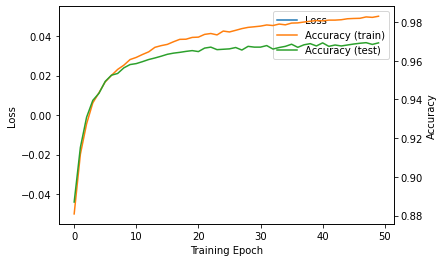

In [96]:
### CLASSIFY MNIST PICTURES WITH UNIFORM(-0.1, 0.1) WEIGHT INITIALIZATION (no momentum)

# create a dataset of 1000 MNIST images, reshaped as single vectors, and labels
data = mnist.load_data()

print('Test for 70000 images')

# The datapoints are in mnistData[0][0]
trainX = data[0][0][:].reshape([60000,28*28])
testX = data[1][0][:].reshape([10000,28*28])

trainX = trainX/255.0
testX = testX/255.0

# The labels are in mnistData[0][1]
trainY = data[0][1][:]
testY = data[1][1][:]

# fit the model to the training data
model = FeedforwardNeuralNetwork([784, 32, 16, 10], 0.001, 0.0, 20.0, 32, 0.0, ['uniform', -0.1, 0.1], 'ReLU', 'cross-entropy')
model.fit(trainX, trainY, testX, testY, 50, 1)

print("Training set accuracy")
trainY = LabelBinarizer().fit_transform(trainY)
predictedY = model.predict(trainX)
predictedY = predictedY.argmax(axis=1)
trainY = trainY.argmax(axis=1)
print(accuracy_score(trainY, predictedY))

print("Test set accuracy")
testY = LabelBinarizer().fit_transform(testY)
predictedY = model.predict(testX)
predictedY = predictedY.argmax(axis=1)
testY = testY.argmax(axis=1)
print(accuracy_score(testY, predictedY))

Test for 70000 images


C:\Users\Ryan\anaconda3\envs\DL\lib\site-packages\ipykernel_launcher.py:320: RuntimeWarning: divide by zero encountered in log
C:\Users\Ryan\anaconda3\envs\DL\lib\site-packages\ipykernel_launcher.py:320: RuntimeWarning: invalid value encountered in multiply
C:\Users\Ryan\anaconda3\envs\DL\lib\site-packages\ipykernel_launcher.py:320: RuntimeWarning: invalid value encountered in log
C:\Users\Ryan\anaconda3\envs\DL\lib\site-packages\numpy\core\fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


[INFO] epoch = 1, loss = inf, training accuracy = 0.972717, test accuracy = 0.967100
[INFO] epoch = 2, loss = inf, training accuracy = 0.981033, test accuracy = 0.975700
[INFO] epoch = 3, loss = inf, training accuracy = 0.986117, test accuracy = 0.979300
[INFO] epoch = 4, loss = inf, training accuracy = 0.990083, test accuracy = 0.979800
[INFO] epoch = 5, loss = inf, training accuracy = 0.992667, test accuracy = 0.981200
[INFO] epoch = 6, loss = inf, training accuracy = 0.993533, test accuracy = 0.982700
[INFO] epoch = 7, loss = inf, training accuracy = 0.993633, test accuracy = 0.981300
[INFO] epoch = 8, loss = inf, training accuracy = 0.994050, test accuracy = 0.979100
[INFO] epoch = 9, loss = inf, training accuracy = 0.996467, test accuracy = 0.983700
[INFO] epoch = 10, loss = inf, training accuracy = 0.996500, test accuracy = 0.983100
[INFO] epoch = 11, loss = inf, training accuracy = 0.997017, test accuracy = 0.983300
[INFO] epoch = 12, loss = inf, training accuracy = 0.997283, te

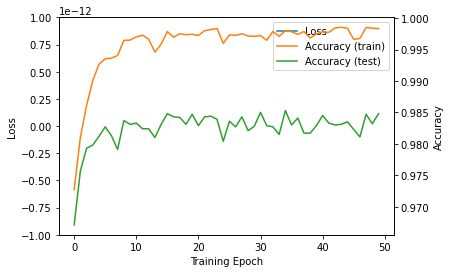

In [100]:
# CLASSIFY MNIST PICTURES WITH UNIFORM(-0.1, 0.1) WEIGHT INITIALIZATION (momentum)

# create a dataset of 1000 MNIST images, reshaped as single vectors, and labels
data = mnist.load_data()

print('Test for 70000 images')

# The datapoints are in mnistData[0][0]
trainX = data[0][0][:].reshape([60000,28*28])
testX = data[1][0][:].reshape([10000,28*28])

trainX = trainX/255.0
testX = testX/255.0

# The labels are in mnistData[0][1]
trainY = data[0][1][:]
testY = data[1][1][:]

# fit the model to the training data
model = FeedforwardNeuralNetwork([784, 256, 64, 10], 0.001, 10.0, 75.0, 32, 0.9, ['uniform', -0.1, 0.1], 'ReLU', 'cross-entropy')
model.fit(trainX, trainY, testX, testY, 50, 1)

print("Training set accuracy")
trainY = LabelBinarizer().fit_transform(trainY)
predictedY = model.predict(trainX)
predictedY = predictedY.argmax(axis=1)
trainY = trainY.argmax(axis=1)
print(accuracy_score(trainY, predictedY))

print("Test set accuracy")
testY = LabelBinarizer().fit_transform(testY)
predictedY = model.predict(testX)
predictedY = predictedY.argmax(axis=1)
testY = testY.argmax(axis=1)
print(accuracy_score(testY, predictedY))

Test for 70000 images


C:\Users\Ryan\anaconda3\envs\DL\lib\site-packages\ipykernel_launcher.py:320: RuntimeWarning: divide by zero encountered in log
C:\Users\Ryan\anaconda3\envs\DL\lib\site-packages\ipykernel_launcher.py:320: RuntimeWarning: invalid value encountered in multiply
C:\Users\Ryan\anaconda3\envs\DL\lib\site-packages\ipykernel_launcher.py:320: RuntimeWarning: invalid value encountered in log
C:\Users\Ryan\anaconda3\envs\DL\lib\site-packages\numpy\core\fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


[INFO] epoch = 1, loss = inf, training accuracy = 0.973817, test accuracy = 0.967800
[INFO] epoch = 2, loss = inf, training accuracy = 0.984267, test accuracy = 0.975200
[INFO] epoch = 3, loss = inf, training accuracy = 0.990217, test accuracy = 0.978300
[INFO] epoch = 4, loss = inf, training accuracy = 0.990217, test accuracy = 0.977100
[INFO] epoch = 5, loss = inf, training accuracy = 0.991883, test accuracy = 0.979000
[INFO] epoch = 6, loss = inf, training accuracy = 0.994633, test accuracy = 0.980100
[INFO] epoch = 7, loss = inf, training accuracy = 0.996300, test accuracy = 0.981700
[INFO] epoch = 8, loss = inf, training accuracy = 0.996133, test accuracy = 0.980500
[INFO] epoch = 9, loss = inf, training accuracy = 0.993817, test accuracy = 0.980700
[INFO] epoch = 10, loss = inf, training accuracy = 0.995950, test accuracy = 0.981200
[INFO] epoch = 11, loss = inf, training accuracy = 0.996950, test accuracy = 0.983500
[INFO] epoch = 12, loss = inf, training accuracy = 0.995817, te

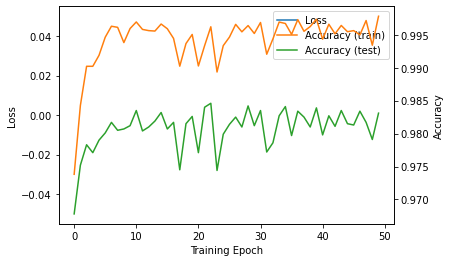

In [101]:
# CLASSIFY MNIST PICTURES WITH UNIFORM(-0.1, 0.1) WEIGHT INITIALIZATION (momentum)

# create a dataset of 1000 MNIST images, reshaped as single vectors, and labels
data = mnist.load_data()

print('Test for 70000 images')

# The datapoints are in mnistData[0][0]
trainX = data[0][0][:].reshape([60000,28*28])
testX = data[1][0][:].reshape([10000,28*28])

trainX = trainX/255.0
testX = testX/255.0

# The labels are in mnistData[0][1]
trainY = data[0][1][:]
testY = data[1][1][:]

# fit the model to the training data
model = FeedforwardNeuralNetwork([784, 512, 128, 32, 10], 0.001, 10.0, 75.0, 32, 0.9, ['uniform', -0.1, 0.1], 'ReLU', 'cross-entropy')
model.fit(trainX, trainY, testX, testY, 50, 1)

print("Training set accuracy")
trainY = LabelBinarizer().fit_transform(trainY)
predictedY = model.predict(trainX)
predictedY = predictedY.argmax(axis=1)
trainY = trainY.argmax(axis=1)
print(accuracy_score(trainY, predictedY))

print("Test set accuracy")
testY = LabelBinarizer().fit_transform(testY)
predictedY = model.predict(testX)
predictedY = predictedY.argmax(axis=1)
testY = testY.argmax(axis=1)
print(accuracy_score(testY, predictedY))

Test for 70000 images


C:\Users\Ryan\anaconda3\envs\DL\lib\site-packages\ipykernel_launcher.py:320: RuntimeWarning: divide by zero encountered in log
C:\Users\Ryan\anaconda3\envs\DL\lib\site-packages\ipykernel_launcher.py:320: RuntimeWarning: invalid value encountered in multiply
C:\Users\Ryan\anaconda3\envs\DL\lib\site-packages\ipykernel_launcher.py:320: RuntimeWarning: invalid value encountered in log
C:\Users\Ryan\anaconda3\envs\DL\lib\site-packages\numpy\core\fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


[INFO] epoch = 1, loss = inf, training accuracy = 0.968000, test accuracy = 0.962900
[INFO] epoch = 2, loss = inf, training accuracy = 0.981583, test accuracy = 0.974700
[INFO] epoch = 3, loss = inf, training accuracy = 0.985483, test accuracy = 0.974900
[INFO] epoch = 4, loss = inf, training accuracy = 0.988883, test accuracy = 0.978200
[INFO] epoch = 5, loss = inf, training accuracy = 0.991417, test accuracy = 0.979700
[INFO] epoch = 6, loss = inf, training accuracy = 0.992000, test accuracy = 0.980000
[INFO] epoch = 7, loss = inf, training accuracy = 0.993583, test accuracy = 0.980200
[INFO] epoch = 8, loss = inf, training accuracy = 0.995017, test accuracy = 0.981200
[INFO] epoch = 9, loss = inf, training accuracy = 0.994600, test accuracy = 0.981400
[INFO] epoch = 10, loss = inf, training accuracy = 0.995983, test accuracy = 0.981700
[INFO] epoch = 11, loss = inf, training accuracy = 0.996533, test accuracy = 0.982800
[INFO] epoch = 12, loss = inf, training accuracy = 0.996750, te

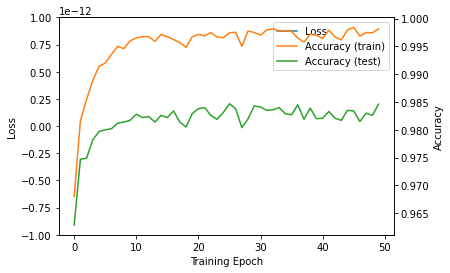

In [102]:
# CLASSIFY MNIST PICTURES WITH LECUN NORMAL WEIGHT INITIALIZATION (momentum)

# create a dataset of 1000 MNIST images, reshaped as single vectors, and labels
data = mnist.load_data()

print('Test for 70000 images')

# The datapoints are in mnistData[0][0]
trainX = data[0][0][:].reshape([60000,28*28])
testX = data[1][0][:].reshape([10000,28*28])

trainX = trainX/255.0
testX = testX/255.0

# The labels are in mnistData[0][1]
trainY = data[0][1][:]
testY = data[1][1][:]

# fit the model to the training data
model = FeedforwardNeuralNetwork([784, 256, 64, 10], 0.001, 10.0, 75.0, 32, 0.9, ['LeCun', 'normal'], 'ReLU', 'cross-entropy')
model.fit(trainX, trainY, testX, testY, 50, 1)

print("Training set accuracy")
trainY = LabelBinarizer().fit_transform(trainY)
predictedY = model.predict(trainX)
predictedY = predictedY.argmax(axis=1)
trainY = trainY.argmax(axis=1)
print(accuracy_score(trainY, predictedY))

print("Test set accuracy")
testY = LabelBinarizer().fit_transform(testY)
predictedY = model.predict(testX)
predictedY = predictedY.argmax(axis=1)
testY = testY.argmax(axis=1)
print(accuracy_score(testY, predictedY))

Test for 70000 images


C:\Users\Ryan\anaconda3\envs\DL\lib\site-packages\ipykernel_launcher.py:320: RuntimeWarning: divide by zero encountered in log
C:\Users\Ryan\anaconda3\envs\DL\lib\site-packages\ipykernel_launcher.py:320: RuntimeWarning: invalid value encountered in multiply
C:\Users\Ryan\anaconda3\envs\DL\lib\site-packages\ipykernel_launcher.py:320: RuntimeWarning: invalid value encountered in log
C:\Users\Ryan\anaconda3\envs\DL\lib\site-packages\numpy\core\fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


[INFO] epoch = 1, loss = inf, training accuracy = 0.969000, test accuracy = 0.963100
[INFO] epoch = 2, loss = inf, training accuracy = 0.981217, test accuracy = 0.972700
[INFO] epoch = 3, loss = inf, training accuracy = 0.985167, test accuracy = 0.973900
[INFO] epoch = 4, loss = inf, training accuracy = 0.988517, test accuracy = 0.978000
[INFO] epoch = 5, loss = inf, training accuracy = 0.990783, test accuracy = 0.979200
[INFO] epoch = 6, loss = inf, training accuracy = 0.994450, test accuracy = 0.981300
[INFO] epoch = 7, loss = inf, training accuracy = 0.994733, test accuracy = 0.980500
[INFO] epoch = 8, loss = inf, training accuracy = 0.994517, test accuracy = 0.979600
[INFO] epoch = 9, loss = inf, training accuracy = 0.995200, test accuracy = 0.979700
[INFO] epoch = 10, loss = inf, training accuracy = 0.994500, test accuracy = 0.979100
[INFO] epoch = 11, loss = inf, training accuracy = 0.996717, test accuracy = 0.983100
[INFO] epoch = 12, loss = inf, training accuracy = 0.996150, te

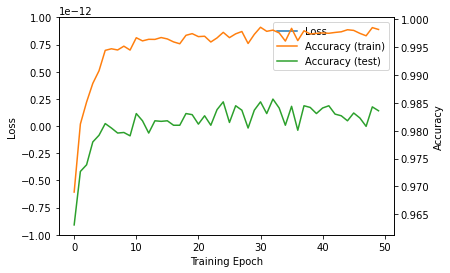

In [103]:
# CLASSIFY MNIST PICTURES WITH LECUN UNIFORM WEIGHT INITIALIZATION (momentum)

# create a dataset of 1000 MNIST images, reshaped as single vectors, and labels
data = mnist.load_data()

print('Test for 70000 images')

# The datapoints are in mnistData[0][0]
trainX = data[0][0][:].reshape([60000,28*28])
testX = data[1][0][:].reshape([10000,28*28])

trainX = trainX/255.0
testX = testX/255.0

# The labels are in mnistData[0][1]
trainY = data[0][1][:]
testY = data[1][1][:]

# fit the model to the training data
model = FeedforwardNeuralNetwork([784, 256, 64, 10], 0.001, 10.0, 75.0, 32, 0.9, ['LeCun', 'uniform'], 'ReLU', 'cross-entropy')
model.fit(trainX, trainY, testX, testY, 50, 1)

print("Training set accuracy")
trainY = LabelBinarizer().fit_transform(trainY)
predictedY = model.predict(trainX)
predictedY = predictedY.argmax(axis=1)
trainY = trainY.argmax(axis=1)
print(accuracy_score(trainY, predictedY))

print("Test set accuracy")
testY = LabelBinarizer().fit_transform(testY)
predictedY = model.predict(testX)
predictedY = predictedY.argmax(axis=1)
testY = testY.argmax(axis=1)
print(accuracy_score(testY, predictedY))

Test for 70000 images


C:\Users\Ryan\anaconda3\envs\DL\lib\site-packages\ipykernel_launcher.py:320: RuntimeWarning: divide by zero encountered in log
C:\Users\Ryan\anaconda3\envs\DL\lib\site-packages\ipykernel_launcher.py:320: RuntimeWarning: invalid value encountered in multiply
C:\Users\Ryan\anaconda3\envs\DL\lib\site-packages\ipykernel_launcher.py:320: RuntimeWarning: invalid value encountered in log
C:\Users\Ryan\anaconda3\envs\DL\lib\site-packages\numpy\core\fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


[INFO] epoch = 1, loss = inf, training accuracy = 0.974967, test accuracy = 0.970900
[INFO] epoch = 2, loss = inf, training accuracy = 0.983800, test accuracy = 0.976300
[INFO] epoch = 3, loss = inf, training accuracy = 0.988183, test accuracy = 0.979300
[INFO] epoch = 4, loss = inf, training accuracy = 0.991567, test accuracy = 0.982400
[INFO] epoch = 5, loss = inf, training accuracy = 0.992017, test accuracy = 0.981500
[INFO] epoch = 6, loss = inf, training accuracy = 0.993583, test accuracy = 0.981900
[INFO] epoch = 7, loss = inf, training accuracy = 0.994017, test accuracy = 0.981800
[INFO] epoch = 8, loss = inf, training accuracy = 0.995400, test accuracy = 0.981900
[INFO] epoch = 9, loss = inf, training accuracy = 0.995667, test accuracy = 0.984100
[INFO] epoch = 10, loss = inf, training accuracy = 0.996217, test accuracy = 0.982200
[INFO] epoch = 11, loss = inf, training accuracy = 0.996267, test accuracy = 0.982200
[INFO] epoch = 12, loss = inf, training accuracy = 0.995900, te

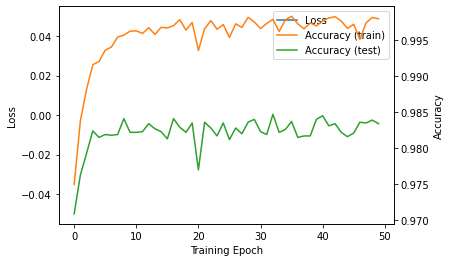

In [104]:
# CLASSIFY MNIST PICTURES WITH GLOROT NORMAL WEIGHT INITIALIZATION (momentum)

# create a dataset of 1000 MNIST images, reshaped as single vectors, and labels
data = mnist.load_data()

print('Test for 70000 images')

# The datapoints are in mnistData[0][0]
trainX = data[0][0][:].reshape([60000,28*28])
testX = data[1][0][:].reshape([10000,28*28])

trainX = trainX/255.0
testX = testX/255.0

# The labels are in mnistData[0][1]
trainY = data[0][1][:]
testY = data[1][1][:]

# fit the model to the training data
model = FeedforwardNeuralNetwork([784, 256, 64, 10], 0.001, 10.0, 75.0, 32, 0.9, ['Glorot', 'normal'], 'ReLU', 'cross-entropy')
model.fit(trainX, trainY, testX, testY, 50, 1)

print("Training set accuracy")
trainY = LabelBinarizer().fit_transform(trainY)
predictedY = model.predict(trainX)
predictedY = predictedY.argmax(axis=1)
trainY = trainY.argmax(axis=1)
print(accuracy_score(trainY, predictedY))

print("Test set accuracy")
testY = LabelBinarizer().fit_transform(testY)
predictedY = model.predict(testX)
predictedY = predictedY.argmax(axis=1)
testY = testY.argmax(axis=1)
print(accuracy_score(testY, predictedY))

Test for 70000 images


C:\Users\Ryan\anaconda3\envs\DL\lib\site-packages\ipykernel_launcher.py:320: RuntimeWarning: divide by zero encountered in log
C:\Users\Ryan\anaconda3\envs\DL\lib\site-packages\ipykernel_launcher.py:320: RuntimeWarning: invalid value encountered in multiply
C:\Users\Ryan\anaconda3\envs\DL\lib\site-packages\ipykernel_launcher.py:320: RuntimeWarning: invalid value encountered in log
C:\Users\Ryan\anaconda3\envs\DL\lib\site-packages\numpy\core\fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


[INFO] epoch = 1, loss = inf, training accuracy = 0.974133, test accuracy = 0.969700
[INFO] epoch = 2, loss = inf, training accuracy = 0.983667, test accuracy = 0.975600
[INFO] epoch = 3, loss = inf, training accuracy = 0.988183, test accuracy = 0.978300
[INFO] epoch = 4, loss = inf, training accuracy = 0.989867, test accuracy = 0.980000
[INFO] epoch = 5, loss = inf, training accuracy = 0.992383, test accuracy = 0.980000
[INFO] epoch = 6, loss = inf, training accuracy = 0.993250, test accuracy = 0.981400
[INFO] epoch = 7, loss = inf, training accuracy = 0.994117, test accuracy = 0.981500
[INFO] epoch = 8, loss = inf, training accuracy = 0.995700, test accuracy = 0.983100
[INFO] epoch = 9, loss = inf, training accuracy = 0.995133, test accuracy = 0.981700
[INFO] epoch = 10, loss = inf, training accuracy = 0.996433, test accuracy = 0.983000
[INFO] epoch = 11, loss = inf, training accuracy = 0.995533, test accuracy = 0.980400
[INFO] epoch = 12, loss = inf, training accuracy = 0.997350, te

C:\Users\Ryan\anaconda3\envs\DL\lib\site-packages\matplotlib\axes\_base.py:2450: RuntimeWarning: overflow encountered in double_scalars
  x0, x1 = inverse_trans.transform([x0t - delta, x1t + delta])


0.9975166666666667
Test set accuracy
0.9854


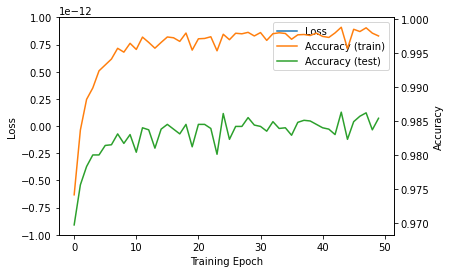

In [105]:
# CLASSIFY MNIST PICTURES WITH GLOROT UNIFORM WEIGHT INITIALIZATION (momentum)

# create a dataset of 1000 MNIST images, reshaped as single vectors, and labels
data = mnist.load_data()

print('Test for 70000 images')

# The datapoints are in mnistData[0][0]
trainX = data[0][0][:].reshape([60000,28*28])
testX = data[1][0][:].reshape([10000,28*28])

trainX = trainX/255.0
testX = testX/255.0

# The labels are in mnistData[0][1]
trainY = data[0][1][:]
testY = data[1][1][:]

# fit the model to the training data
model = FeedforwardNeuralNetwork([784, 256, 64, 10], 0.001, 10.0, 75.0, 32, 0.9, ['Glorot', 'uniform'], 'ReLU', 'cross-entropy')
model.fit(trainX, trainY, testX, testY, 50, 1)

print("Training set accuracy")
trainY = LabelBinarizer().fit_transform(trainY)
predictedY = model.predict(trainX)
predictedY = predictedY.argmax(axis=1)
trainY = trainY.argmax(axis=1)
print(accuracy_score(trainY, predictedY))

print("Test set accuracy")
testY = LabelBinarizer().fit_transform(testY)
predictedY = model.predict(testX)
predictedY = predictedY.argmax(axis=1)
testY = testY.argmax(axis=1)
print(accuracy_score(testY, predictedY))

### Annealing the Learning Rate

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelBinarizer

# This class is for a fully-connected feedforward neural network using stochastic gradient descent
#
# Inputs:
#
#   layers - a list of numbers of neurons in each layer
#
#   alpha - learning rate
#
#   annealing - a list specifying the annealing schedule for the learning rate
#     'none' - use a constant learning rate
#     ['step', k] - decay the learning rate to 0 at k evenly spaced times with identical steps
#     ['exp', k] - decay the learning rate exponentially alpha = alpha0(exp(-k*epoch))
#     ['inv', k] - decay the learning rate as alpha = alpha0/(1 + k*epoch)
#
#   lambda1 - L1 penalty coefficient (positive)
#
#   lambda2 - L2 penalty coefficient (positive)
#
#   batchSize - size of mini-batches for SGD
#
#   gamma - momentum coefficient (between 0 and 1)
#
#   initialization - a list specifying the initalization
#     ['normal', k] - standard normal random variables divided by k
#     ['uniform', a, b] - uniform random variables between a and b
#     'Nielsen' - standard normal random variables divided by the number of nodes in the next layer
#     ['LeCun', 'uniform' or 'normal'] - normal or uniform random variables centered at 0 with standard deviation sqrt(3/nodes in previous
#                                        layer) or lower/upper bounds of +/- the same, respectively
#     ['Glorot', 'uniform' or 'normal'] - normal or uniform random variables centered at 0 with standard deviation sqrt(1/mean of nodes in
#                                         previous and next layers) or lower/upper bounds of +/- the same, respectively
#     ['He', 'uniform' or 'normal'] - normal or uniform random variables centered at 0 with standard deviation sqrt(6/nodes in previous
#                                     layer) or lower/upper bounds of +/- the same, respectively
#
#   activations - string to choose which activation functions to use:
#     'sigmoid' - sigmoid function
#     'ReLU' - rectified linear unit
#     'ELU' - exponential linear unit
#
#   loss - string to choose which loss function to use:
#     'sum-of-squares'
#     'cross-entropy'

class FeedforwardNeuralNetwork:
    
    def __init__(self, layers, alpha = 0.1, annealing = 'none', lambda1 = 0, lambda2 = 0, batchSize = 32, gamma = 0.0,
                 initialization = 'normal', activations = 'sigmoid', loss = 'sum-of-squares'):
        # list of weight matrices between layers
        self.W = []
        
        # network architecture will be a vector of numbers of nodes for each layer
        self.layers = layers
        
        # learning rate
        self.alpha = alpha
        
        # annealing policy
        self.annealing = annealing
        
        # L1 penalty coefficient
        self.lambda1 = lambda1
        
        # L2 penalty coefficient
        self.lambda2 = lambda2
        
        # batch size
        self.batchSize = batchSize
        
        # momentum parameter
        self.gamma = gamma
        
        # activation type
        self.activation = activations
        
        # loss function
        self.loss = loss
        
        # initialize the weights -- this is our initial guess for gradient descent
        
        # initialize the weights between layers (up to the next-to-last one) as normal random variables
        if initialization[0] == 'normal':
            for i in np.arange(0, len(layers) - 2):
                self.W.append(np.random.normal(0.0, 1.0, size=(layers[i] + 1, layers[i + 1] + 1))/initialization[1])

            # initialize weights between the last two layers (we don't want bias for the last one)
            self.W.append(np.random.normal(0.0, 1.0, size=(layers[-2] + 1, layers[-1]))/initialization[1])
            
        if initialization[0] == 'uniform':
            # initialize the weights between layers (up to the next-to-last one) as normal random variables
            for i in np.arange(0, len(layers) - 2):
                self.W.append(np.random.uniform(initialization[1], initialization[2], size=(layers[i] + 1, layers[i + 1] + 1)))

            # initialize weights between the last two layers (we don't want bias for the last one)
            self.W.append(np.random.uniform(initialization[1], initialization[2], size=(layers[-2] + 1, layers[-1])))
            
        if initialization == 'Nielsen':
            # initialize the weights between layers (up to the next-to-last one) as normal random variables
            for i in np.arange(0, len(layers) - 2):
                self.W.append(np.random.normal(0.0, 1.0, size=(layers[i] + 1, layers[i + 1] + 1))/layers[i+1])

            # initialize weights between the last two layers (we don't want bias for the last one)
            self.W.append(np.random.normal(0.0, 1.0, size=(layers[-2] + 1, layers[-1]))/layers[-1])
            
        # LeCun, Glorot, and He initialization
        if initialization[0] in ['LeCun', 'Glorot', 'He']:
            # initialize the weights between layers (up to the next-to-last one) as normal random variables
            for i in np.arange(0, len(layers) - 2):
                
                # define the limit term for normal random variables
                
                # LeCun initialization ("efficient backprop", default initialization in PyTorch)
                if initialization[0] == 'LeCun':
                    limit = np.sqrt(1.0 / layers[i+1])
                    
                # Glorot initialization (default initialization in Keras)
                elif initialization[0] == 'Glorot':
                    mean = (layers[i] + layers[i+1])/2.0
                    limit = np.sqrt(1.0 / mean)
                    
                # He initialization (typically used for very deep nets with PReLU activation)
                elif initialization[0] == 'He':
                    limit = np.sqrt(2.0 / layers[i+1])
                
                # generate the weights
                if initialization[1] == 'normal':
                    self.W.append(np.random.normal(0.0, limit, size=(layers[i] + 1, layers[i + 1] + 1)))
                    
                elif initialization[1] == 'uniform':
                    limit *= np.sqrt(3.0)
                    self.W.append(np.random.uniform(-limit, limit, size=(layers[i] + 1, layers[i + 1] + 1)))

            # initialize weights between the last two layers (we don't want bias for the last one)

            # define the limit term for normal random variables
            if initialization[0] == 'LeCun':
                limit = np.sqrt(1.0 / layers[-2])
                
            elif initialization[0] == 'Glorot':
                mean = (layers[-2] + layers[-1])/2.0
                limit = np.sqrt(1.0 / mean)
                    
            elif initialization[0] == 'He':
                limit = np.sqrt(2.0 / layers[-2])
            
            # initialize the weights
            if initialization[1] == 'normal':
                self.W.append(np.random.normal(0.0, limit, size=(layers[-2] + 1, layers[-1])))
                
            elif initialization[1] == 'uniform':
                limit *= np.sqrt(3.0)
                self.W.append(np.random.uniform(-limit, limit, size=(layers[-2] + 1, layers[-1])))
        
    # define the activation function
    def activate(self, x):
        if self.activation == 'sigmoid':
            return 1.0 / (1 + np.exp(-x))

        if self.activation == 'ReLU':
            return x*(x >= 0)
        
        if self.activation == 'ELU':
            return x*(x >= 0) + 0.1*(np.exp(x) - 1)*(x < 0)
    
    # define the activation derivative (where x is the INPUT to activation function)
    def activationDerivative(self, x):
        if self.activation == 'sigmoid':
            return self.activate(x) * (1 - self.activate(x))
        
        if self.activation == 'ReLU':
            return x >= 0
        
        if self.activation == 'ELU':
            return 1*(x >= 0) + 0.1*np.exp(x)*(x < 0)
    
    def getNextBatch(self, X, y, batchSize):
        for i in np.arange(0, X.shape[0], batchSize):
            yield (X[i:i + batchSize], y[i:i + batchSize])
    
    # fit the model
    def fit(self, X, y, testX, testY, epochs = 10000, update = 1000, printPerformance = True):
        # add a column of ones to the end of X
        X = np.hstack((X, np.ones([X.shape[0],1])))
        losses = []
        trainAccuracies = []
        testAccuracies = []
        trainY = y
        
        numberOfExamples = X.shape[0]
        
        # use one-hot encoding for the training labels
        y = LabelBinarizer().fit_transform(y)
        
        v = []
        for layer in np.arange(0,len(self.W)):
            v.append(np.zeros(self.W[layer].shape))
            
        alpha = self.alpha

        for epoch in np.arange(0,epochs):
            
            if self.annealing[0] == 'step':
                stepSize = self.alpha/self.annealing[1]
                if epochs > 0 and epoch % self.annealing[1] == 0:
                    alpha -= stepSize
                    print(alpha)
                
            elif self.annealing[0] == 'exp':
                alpha = self.alpha * np.exp(-self.annealing[1] * epoch)
                    
            elif self.annealing[0] == 'inv':
                alpha = self.alpha / (1 + self.annealing[1] * epoch)
            
            # randomize the examples
            p = np.arange(0,X.shape[0])
            np.random.shuffle(p)
            X = X[p]
            y = y[p]

            # feed forward, backprop, and weight update
            for (x, target) in self.getNextBatch(X, y, self.batchSize):
                # make a list of output activations from the first layer
                # (just the original x values)
                A = [np.atleast_2d(x)]
                Z = [np.atleast_2d(x)]
                
                # feed forward
                for layer in np.arange(0, len(self.W)):
                    
                    # feed through one layer and apply sigmoid activation
                    net = A[layer].dot(self.W[layer])
                    out = self.activate(net)
                    
                    # add our network output to the list of activations
                    A.append(out)
                    Z.append(net)
                    
                # backpropagation (coming soon!)
                error = A[-1] - target
                
                if self.loss == 'sum-of-squares':
                    D = [error * self.activationDerivative(Z[-1])]
                    
                if self.loss == 'cross-entropy':
                    D = [error]
                
                # loop backwards over the layers to build up deltas
                for layer in np.arange(len(A) - 2, 0, -1):
                    delta = D[-1].dot(self.W[layer].T)
                    delta = delta * self.activationDerivative(Z[layer])
                    D.append(delta)
                    
                # reverse the deltas since we looped in reverse
                D = D[::-1]
                
                # weight update
                for layer in np.arange(0, len(self.W)):
                    gradient = (A[layer].T.dot(D[layer])
                                + (self.lambda1 / numberOfExamples) * np.sign(self.W[layer])
                                + (self.lambda2 / numberOfExamples) * self.W[layer])
                    
                    v[layer] = self.gamma * v[layer] + alpha * gradient
                    self.W[layer] -= v[layer]
              
            # print the loss (or maybe more) each 'update' number of epochs
            if (epoch + 1) % update == 0:
                loss = self.computeLoss(X,y)

                # if we chose, compute the accuracy (this makes it run slower)
                if printPerformance:
                    predictedY = self.predict(testX)
                    predictedY = predictedY.argmax(axis=1)
                    testAccuracy = accuracy_score(testY, predictedY)           

                    predictedY = self.predict(trainX)
                    predictedY = predictedY.argmax(axis=1)
                    trainAccuracy = accuracy_score(trainY, predictedY)

                    testAccuracies.append(testAccuracy)
                    trainAccuracies.append(trainAccuracy)
                    losses.append(loss)
                    print("[INFO] epoch = {}, loss = {:.6f}, training accuracy = {:.6f}, test accuracy = {:.6f}".format(epoch + 1, loss, trainAccuracy, testAccuracy))
                    
                # otherwise, simply print the training loss
                else:
                    losses.append(loss)
                    print("[INFO] epoch = {}, loss = {:.6f}".format(epoch + 1, loss))

        # if we chose to print the performance, plot loss, training accuracy, and test accuracy for each epoch
        if printPerformance:
            fig, ax1 = plt.subplots()

            # plot the losses
            p1 = ax1.plot(np.arange(0, epochs, update), losses, label = 'Loss')
            ax1.set_xlabel('Training Epoch')
            ax1.set_ylabel('Loss')

            # make another y axis using the same x axis
            ax2 = ax1.twinx()
            
            # plot the accuracy
            p2 = ax2.plot(np.arange(0, epochs, update), trainAccuracies, label = 'Accuracy (train)', color = 'tab:orange')
            p3 = ax2.plot(np.arange(0, epochs, update), testAccuracies, label = 'Accuracy (test)', color = 'tab:green')
            ax2.set_ylabel('Accuracy')

            # add a legend
            ps = p1 + p2 + p3
            labs = [p.get_label() for p in ps]
            ax1.legend(ps, labs, loc=0)
            
    # feed data into the network and compute the outputs
    def predict(self, X, addOnes = True):
        # initialize data, be sure it's the right dimension
        p = np.atleast_2d(X)
        
        # add a column of 1s for bias
        if addOnes:
            p = np.hstack((p, np.ones([X.shape[0],1])))
        
        # feed forward!
        for layer in np.arange(0, len(self.W)):
            p = self.activate(np.dot(p, self.W[layer]))
            
        return p
    
    # compute the loss function
    def computeLoss(self, X, y):
        # initialize data, be sure it's the right dimension
        y = np.atleast_2d(y)
        
        # feed the datapoints through the network to get predicted outputs
        predictions = self.predict(X, addOnes = False)
        
        # if the loss function is sum of squares, compute it
        if self.loss == 'sum-of-squares':
            loss = np.sum((predictions - y)**2) / 2.0
            
        # if the loss function is cross-entropy, compute it
        if self.loss == 'cross-entropy':
            loss = np.sum(np.nan_to_num(-y*np.log(predictions)-(1-y)*np.log(1-predictions)))
            
        # if there is an L1 penalty, compute it and add it to the loss
        if self.lambda1 != 0:
            # compute the L1 penalty 
            L1penalty = 0

            for layer in np.arange(0,len(self.W)):
                L1penalty += np.sum(np.abs(self.W[layer]))
        
            # add the L1 penalty to the loss
            loss = loss + (self.lambda1 / X.shape[0]) * L1penalty
            
        # if there is an L2 penalty, compute it and add it to the loss
        if self.lambda2 != 0:
            # compute the L2 penalty 
            L2penalty = 0

            for layer in np.arange(0,len(self.W)):
                L2penalty += np.sum(self.W[layer] ** 2)
        
            # add the L2 penalty to the loss
            loss = loss + (self.lambda2 / X.shape[0]) * L2penalty
        
        return loss

In [11]:
# CLASSIFY MNIST PICTURES WITH GLOROT UNIFORM WEIGHT INITIALIZATION, MOMENTUM, AND EXPONENTIAL ANNEALING)

# create a dataset of 1000 MNIST images, reshaped as single vectors, and labels
data = mnist.load_data()

# The datapoints are in mnistData[0][0]
#X = data[0][0][:1000].reshape([1000,28*28])
#X = X/255.0

# The labels are in mnistData[0][1]
#Y = data[0][1][:1000]

# randomly choose 75% of the data to be the training set and 25% for the testing set
#(trainX, testX, trainY, testY) = train_test_split(X, Y, test_size = 0.25)

print('Test for 70000 images')

# The datapoints are in mnistData[0][0]
trainX = data[0][0][:].reshape([60000,28*28])
testX = data[1][0][:].reshape([10000,28*28])

trainX = trainX/255.0
testX = testX/255.0

# The labels are in mnistData[0][1]
trainY = data[0][1][:]
testY = data[1][1][:]

# fit the model to the training data
model = FeedforwardNeuralNetwork([784, 256, 64, 10], 0.001, ['exp', 1.0], 10.0, 75.0, 32, 0.9, ['Glorot', 'uniform'], 'ReLU', 'cross-entropy')
model.fit(trainX, trainY, testX, testY, 50, 1)

print("Training set accuracy")
trainY = LabelBinarizer().fit_transform(trainY)
predictedY = model.predict(trainX)
predictedY = predictedY.argmax(axis=1)
trainY = trainY.argmax(axis=1)
print(accuracy_score(trainY, predictedY))

print("Test set accuracy")
testY = LabelBinarizer().fit_transform(testY)
predictedY = model.predict(testX)
predictedY = predictedY.argmax(axis=1)
testY = testY.argmax(axis=1)
print(accuracy_score(testY, predictedY))

Test for 70000 images


C:\Users\Ryan\anaconda3\envs\DL\lib\site-packages\ipykernel_launcher.py:343: RuntimeWarning: divide by zero encountered in log
C:\Users\Ryan\anaconda3\envs\DL\lib\site-packages\ipykernel_launcher.py:343: RuntimeWarning: invalid value encountered in multiply
C:\Users\Ryan\anaconda3\envs\DL\lib\site-packages\ipykernel_launcher.py:343: RuntimeWarning: invalid value encountered in log
C:\Users\Ryan\anaconda3\envs\DL\lib\site-packages\numpy\core\fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


[INFO] epoch = 1, loss = inf, training accuracy = 0.973700, test accuracy = 0.968400


KeyboardInterrupt: 

Test for 70000 images


C:\Users\Ryan\anaconda3\envs\DL\lib\site-packages\ipykernel_launcher.py:343: RuntimeWarning: divide by zero encountered in log
C:\Users\Ryan\anaconda3\envs\DL\lib\site-packages\ipykernel_launcher.py:343: RuntimeWarning: invalid value encountered in multiply
C:\Users\Ryan\anaconda3\envs\DL\lib\site-packages\ipykernel_launcher.py:343: RuntimeWarning: invalid value encountered in log
C:\Users\Ryan\anaconda3\envs\DL\lib\site-packages\numpy\core\fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


[INFO] epoch = 1, loss = inf, training accuracy = 0.975250, test accuracy = 0.970800
[INFO] epoch = 2, loss = inf, training accuracy = 0.983617, test accuracy = 0.975900
[INFO] epoch = 3, loss = inf, training accuracy = 0.986117, test accuracy = 0.977700
[INFO] epoch = 4, loss = inf, training accuracy = 0.986917, test accuracy = 0.978500
[INFO] epoch = 5, loss = inf, training accuracy = 0.987033, test accuracy = 0.978600
[INFO] epoch = 6, loss = inf, training accuracy = 0.987067, test accuracy = 0.978400
[INFO] epoch = 7, loss = inf, training accuracy = 0.987083, test accuracy = 0.978700
[INFO] epoch = 8, loss = inf, training accuracy = 0.987100, test accuracy = 0.978600
[INFO] epoch = 9, loss = inf, training accuracy = 0.987083, test accuracy = 0.978600
[INFO] epoch = 10, loss = inf, training accuracy = 0.987083, test accuracy = 0.978600
[INFO] epoch = 11, loss = inf, training accuracy = 0.987083, test accuracy = 0.978600
[INFO] epoch = 12, loss = inf, training accuracy = 0.987083, te

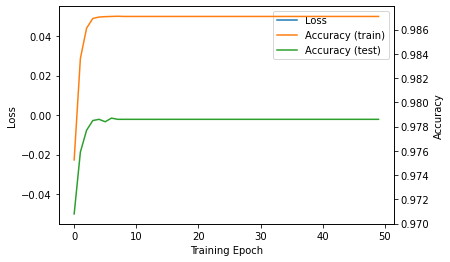

In [39]:
# CLASSIFY MNIST PICTURES WITH GLOROT UNIFORM WEIGHT INITIALIZATION, MOMENTUM, AND EXPONENTIAL ANNEALING)

# create a dataset of 1000 MNIST images, reshaped as single vectors, and labels
data = mnist.load_data()

# create a dataset of 1000 MNIST images, reshaped as single vectors, and labels
data = mnist.load_data()

# The datapoints are in mnistData[0][0]
#X = data[0][0][:000].reshape([1000,28*28])
#X = X/255.0

# The labels are in mnistData[0][1]
#Y = data[0][1][:1000]

# randomly choose 75% of the data to be the training set and 25% for the testing set
#(trainX, testX, trainY, testY) = train_test_split(X, Y, test_size = 0.25)

print('Test for 70000 images')

# The datapoints are in mnistData[0][0]
trainX = data[0][0][:].reshape([60000,28*28])
testX = data[1][0][:].reshape([10000,28*28])

trainX = trainX/255.0
testX = testX/255.0

# The labels are in mnistData[0][1]
trainY = data[0][1][:]
testY = data[1][1][:]

# fit the model to the training data
model = FeedforwardNeuralNetwork([784, 256, 64, 10], 0.001, ['exp', 1.0], 10.0, 75.0, 32, 0.9, ['Glorot', 'uniform'], 'ReLU', 'cross-entropy')
model.fit(trainX, trainY, testX, testY, 50, 1)

print("Training set accuracy")
trainY = LabelBinarizer().fit_transform(trainY)
predictedY = model.predict(trainX)
predictedY = predictedY.argmax(axis=1)
trainY = trainY.argmax(axis=1)
print(accuracy_score(trainY, predictedY))

print("Test set accuracy")
testY = LabelBinarizer().fit_transform(testY)
predictedY = model.predict(testX)
predictedY = predictedY.argmax(axis=1)
testY = testY.argmax(axis=1)
print(accuracy_score(testY, predictedY))

Test for 70000 images
0.0009


C:\Users\Ryan\anaconda3\envs\DL\lib\site-packages\ipykernel_launcher.py:343: RuntimeWarning: divide by zero encountered in log
C:\Users\Ryan\anaconda3\envs\DL\lib\site-packages\ipykernel_launcher.py:343: RuntimeWarning: invalid value encountered in multiply
C:\Users\Ryan\anaconda3\envs\DL\lib\site-packages\ipykernel_launcher.py:343: RuntimeWarning: invalid value encountered in log
C:\Users\Ryan\anaconda3\envs\DL\lib\site-packages\numpy\core\fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


[INFO] epoch = 1, loss = inf, training accuracy = 0.949200, test accuracy = 0.932400
[INFO] epoch = 2, loss = inf, training accuracy = 0.968800, test accuracy = 0.949200
[INFO] epoch = 3, loss = inf, training accuracy = 0.982933, test accuracy = 0.957600
[INFO] epoch = 4, loss = inf, training accuracy = 0.987733, test accuracy = 0.959600
[INFO] epoch = 5, loss = inf, training accuracy = 0.991600, test accuracy = 0.960800
[INFO] epoch = 6, loss = 179769313486231570814527423731704356798070567525844996598917476803157260780028538760589558632766878171540458953514382464234321326889464182768467546703537516986049910576551282076245490090389328944075868508455133942304583236903222948165808559332123348274797826204144723168738177180919299881250404026184124858368.000000, training accuracy = 0.990000, test accuracy = 0.964000
[INFO] epoch = 7, loss = inf, training accuracy = 0.993600, test accuracy = 0.957600
[INFO] epoch = 8, loss = 1300.140418, training accuracy = 0.996667, test accuracy = 0.966400

C:\Users\Ryan\anaconda3\envs\DL\lib\site-packages\matplotlib\axes\_base.py:2450: RuntimeWarning: overflow encountered in double_scalars
  x0, x1 = inverse_trans.transform([x0t - delta, x1t + delta])


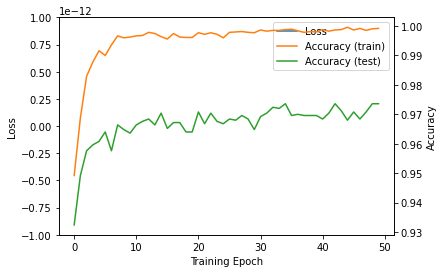

In [37]:
# CLASSIFY MNIST PICTURES WITH GLOROT UNIFORM WEIGHT INITIALIZATION, MOMENTUM, AND EXPONENTIAL ANNEALING

# create a dataset of MNIST images, reshaped as single vectors, and labels
data = mnist.load_data()

# The datapoints are in mnistData[0][0]
#X = data[0][0][:10000].reshape([10000,28*28])
#X = X/255.0

# The labels are in mnistData[0][1]
#Y = data[0][1][:10000]

# randomly choose 75% of the data to be the training set and 25% for the testing set
#(trainX, testX, trainY, testY) = train_test_split(X, Y, test_size = 0.25)

print('Test for 70000 images')

# The datapoints are in mnistData[0][0]
#trainX = data[0][0][:].reshape([60000,28*28])
#testX = data[1][0][:].reshape([10000,28*28])

#trainX = trainX/255.0
#testX = testX/255.0

# The labels are in mnistData[0][1]
#trainY = data[0][1][:]
#testY = data[1][1][:]

# fit the model to the training data
model = FeedforwardNeuralNetwork([784, 256, 64, 10], 0.001, ['step', 10], 10.0, 75.0, 32, 0.9, ['Glorot', 'uniform'], 'ReLU', 'cross-entropy')
model.fit(trainX, trainY, testX, testY, 50, 1)

print("Training set accuracy")
trainY = LabelBinarizer().fit_transform(trainY)
predictedY = model.predict(trainX)
predictedY = predictedY.argmax(axis=1)
trainY = trainY.argmax(axis=1)
print(accuracy_score(trainY, predictedY))

print("Test set accuracy")
testY = LabelBinarizer().fit_transform(testY)
predictedY = model.predict(testX)
predictedY = predictedY.argmax(axis=1)
testY = testY.argmax(axis=1)
print(accuracy_score(testY, predictedY))

Test for 70000 images


C:\Users\Ryan\anaconda3\envs\DL\lib\site-packages\ipykernel_launcher.py:343: RuntimeWarning: divide by zero encountered in log
C:\Users\Ryan\anaconda3\envs\DL\lib\site-packages\ipykernel_launcher.py:343: RuntimeWarning: invalid value encountered in multiply
C:\Users\Ryan\anaconda3\envs\DL\lib\site-packages\ipykernel_launcher.py:343: RuntimeWarning: invalid value encountered in log
C:\Users\Ryan\anaconda3\envs\DL\lib\site-packages\numpy\core\fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


[INFO] epoch = 1, loss = inf, training accuracy = 0.942933, test accuracy = 0.926800
[INFO] epoch = 2, loss = inf, training accuracy = 0.968667, test accuracy = 0.939600
[INFO] epoch = 3, loss = inf, training accuracy = 0.977467, test accuracy = 0.950800
[INFO] epoch = 4, loss = inf, training accuracy = 0.980667, test accuracy = 0.950400
[INFO] epoch = 5, loss = inf, training accuracy = 0.983867, test accuracy = 0.953200
[INFO] epoch = 6, loss = inf, training accuracy = 0.984000, test accuracy = 0.954800
[INFO] epoch = 7, loss = inf, training accuracy = 0.985200, test accuracy = 0.955200
[INFO] epoch = 8, loss = inf, training accuracy = 0.986667, test accuracy = 0.957200
[INFO] epoch = 9, loss = inf, training accuracy = 0.987200, test accuracy = 0.958400
[INFO] epoch = 10, loss = inf, training accuracy = 0.987467, test accuracy = 0.957200
[INFO] epoch = 11, loss = inf, training accuracy = 0.988267, test accuracy = 0.958000
[INFO] epoch = 12, loss = inf, training accuracy = 0.989467, te

C:\Users\Ryan\anaconda3\envs\DL\lib\site-packages\matplotlib\axes\_base.py:2450: RuntimeWarning: overflow encountered in double_scalars
  x0, x1 = inverse_trans.transform([x0t - delta, x1t + delta])


0.9944
Test set accuracy
0.964


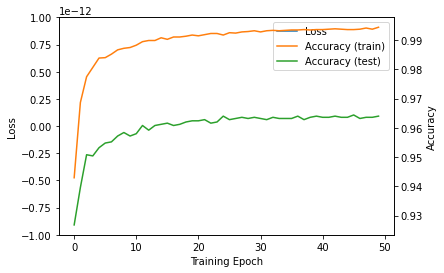

In [38]:
# CLASSIFY MNIST PICTURES WITH GLOROT UNIFORM WEIGHT INITIALIZATION, MOMENTUM, AND EXPONENTIAL ANNEALING

# create a dataset of MNIST images, reshaped as single vectors, and labels
data = mnist.load_data()

# The datapoints are in mnistData[0][0]
#X = data[0][0][:10000].reshape([10000,28*28])
#X = X/255.0

# The labels are in mnistData[0][1]
#Y = data[0][1][:10000]

# randomly choose 75% of the data to be the training set and 25% for the testing set
#(trainX, testX, trainY, testY) = train_test_split(X, Y, test_size = 0.25)

print('Test for 70000 images')

# The datapoints are in mnistData[0][0]
#trainX = data[0][0][:].reshape([60000,28*28])
#testX = data[1][0][:].reshape([10000,28*28])

#trainX = trainX/255.0
#testX = testX/255.0

# The labels are in mnistData[0][1]
#trainY = data[0][1][:]
#testY = data[1][1][:]

# fit the model to the training data
model = FeedforwardNeuralNetwork([784, 256, 64, 10], 0.001, ['inv', 1.0], 10.0, 75.0, 32, 0.9, ['Glorot', 'uniform'], 'ReLU', 'cross-entropy')
model.fit(trainX, trainY, testX, testY, 50, 1)

print("Training set accuracy")
trainY = LabelBinarizer().fit_transform(trainY)
predictedY = model.predict(trainX)
predictedY = predictedY.argmax(axis=1)
trainY = trainY.argmax(axis=1)
print(accuracy_score(trainY, predictedY))

print("Test set accuracy")
testY = LabelBinarizer().fit_transform(testY)
predictedY = model.predict(testX)
predictedY = predictedY.argmax(axis=1)
testY = testY.argmax(axis=1)
print(accuracy_score(testY, predictedY))